In [17]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split,RepeatedKFold,StratifiedShuffleSplit
from model import Selection
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter

In [13]:
##### settings #####
rng_seed = 42 # control reproducibility
ran_sta = 3 
method = "lasso"
Counts=Counter()

In [35]:
# read data for diagnosis prediction
Xtrain = pd.read_excel('Data/Xtrain.xlsx',index_col=0)
ytrain = pd.read_excel('Data/ytrain.xlsx',index_col=0)
Xtest = pd.read_excel('Data/Xtest.xlsx',index_col=0)
ytest = pd.read_excel('Data/ytest.xlsx',index_col=0)

Xtrain.drop(['sample_id'],axis=1,inplace=True)
Xtest.drop(['sample_id'],axis=1,inplace=True)

metas=list(Xtrain.columns)
ytrain = np.array(ytrain.state)
ytrain = ytrain.astype(np.float32)
ytest = np.array(ytest.state)
ytest = ytest.astype(np.float32)

Xtrain=Xtrain.values
Xtest=Xtest.values
print("train test info:")
print("train, normal-patients", np.unique(ytrain,return_counts=True))
print("test, normal-patients", np.unique(ytest,return_counts=True))

train test info:
train, normal-patients (array([0., 1.], dtype=float32), array([187,  97]))
test, normal-patients (array([0., 1.], dtype=float32), array([94, 48]))


In [15]:
def test(model, Xtest, ytest, metric='auc'):
    pred = model.predict(Xtest)
    prob = model.predict_proba(Xtest)
    print("ytest,pred:",ytest,pred)
    s = f1_score(ytest, pred)
    print("ytest,prob:",ytest,prob[:,-1])
    s1 = roc_auc_score(ytest, prob[:,-1])
    print("f1 score:", s)
    print("auroc score:", s1)
    return (s,s1)
         
def train_test(Xtrain, ytrain, Xtest, ytest, test_fn="RF", seed=12306, metric='auc'):
    model = RF(n_estimators=100,random_state=seed)
    model.fit(Xtrain, ytrain)
    print("evaluate on train set:")
    test(model, Xtrain, ytrain, metric)
    print("evaluate on test set:")
    s = test(model, Xtest, ytest, metric)
    return model, s

In [18]:
##### Feature selection #####
discovery_set=pd.read_excel('Data/discovery_set.xlsx',index_col=0)
discovery_set['state']=discovery_set.apply(lambda a:0 if a['type']=='N' else 1,axis=1)
labels=discovery_set['type']
plasma_df=discovery_set.copy()
batch1=plasma_df[(plasma_df['batch']=='batch1')]
batch1.reset_index(drop=True,inplace=True)
batch2=plasma_df[(plasma_df['batch']=='batch2')]
batch2.reset_index(drop=True,inplace=True)
batch3=plasma_df[plasma_df['batch']=='batch3']
batch3.reset_index(drop=True,inplace=True)

for i in range(0,10000):
    print("This is round %d"%(i))
    random_state=i
    split=StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=random_state)
    for train_index, test_index in split.split(batch1,batch1['type']):
        batch1_train_set=batch1.loc[train_index]
        batch1_test_set=batch1.loc[test_index] #batch1
    for train_index, test_index in split.split(batch2,batch2['type']):
        batch2_train_set=batch2.loc[train_index]
        batch2_test_set=batch2.loc[test_index] #batch2
    for train_index, test_index in split.split(batch3,batch3['type']):
        batch3_train_set=batch3.loc[train_index]
        batch3_test_set=batch3.loc[test_index] #batch3

    # 合并3个batch的training set 和testing set数据
    Xtrain_stratified=pd.concat([batch1_train_set,batch2_train_set,batch3_train_set],axis=0)
    Xtrain_stratified.reset_index(drop=True,inplace=True)
    Xtest_stratified=pd.concat([batch1_test_set,batch2_test_set,batch3_test_set],axis=0)
    Xtest_stratified.reset_index(drop=True,inplace=True)

    # 分类数据
    ytrain_stratified=Xtrain_stratified['state']
    ytest_stratified=Xtest_stratified['state']
    # 丢弃不需要的列
    Xtrain_stratified.drop(['Batch','type','batch','state'],axis=1,inplace=True)
    Xtest_stratified.drop(['Batch','type','batch','state'],axis=1,inplace=True)

    Xtrain=Xtrain_stratified
    Xtest=Xtest_stratified
    ytrain=pd.DataFrame(ytrain_stratified)
    ytest=pd.DataFrame(ytest_stratified)

    Xtrain.drop(['sample_id'],axis=1,inplace=True)
    Xtest.drop(['sample_id'],axis=1,inplace=True)

    metas=list(Xtrain.columns)
    ytrain = np.array(ytrain.state)
    ytrain = ytrain.astype(np.float32)
    ytest = np.array(ytest.state)
    ytest = ytest.astype(np.float32)

    Xtrain=Xtrain.values
    Xtest=Xtest.values
    class ArgsClass:
        def __init__(self, k=5, alpha=0.05):
            self.k=k
            self.alpha=alpha
    args=ArgsClass(k=10, alpha=0.005)
    sel = Selection(method, args)
    sel.fit(Xtrain, ytrain)  # select on whole training set
    mb = sel.mb_
    #print("selected feature index: ", mb)
    #print("selected meta names: ", [metas[x] for x in mb])
    #print("with selected featues:")
    Counts=Counter(mb)+Counts

##### select top rank features #####
Counts_metas = pd.DataFrame(Counts.most_common(),columns=['metas_index',"counts"])
Counts_metas['metas'] = Counts_metas.apply(lambda a:metas[a['metas_index']],axis=1)
# 'Glycerate-2P_Glycerate-3P_neg-006','Citraconic acid_neg-025','Pyridoxine_pos-137','Argininosuccinic acid_pos-039'
# The above metabolites are excluded as characteristics due to poor peak shapes in mass spectrometry
Counts_metas_selected=Counts_metas[~Counts_metas['metas'].isin(['Glycerate-2P_Glycerate-3P_neg-006','Citraconic acid_neg-025','Pyridoxine_pos-137','Argininosuccinic acid_pos-039'])]
Counts_metas_selected.reset_index(drop=True,inplace=True)
Counts_metas=Counts_metas_selected
selected_feature_index=list(Counts_metas['metas_index'][0:10])

This is round 0
imp: 35.53654951657415
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80 100 127 132 137 140]
over max_features [  4  15  66  78  80 100 127 132 137 140]
This is round 1
imp: 6.9156168385772245
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 100 110 125 127 132 137 140]
over max_features [  4  78  80 100 110 125 127 132 137 140]
This is round 2
imp: 5.674435482531698
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  76  78  80 100 110 125 127 137 140]
over max_features [ 66  76  78  80 100 110 125 127 137 140]
This is round 3
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.

imp: 4.362585839724081
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 125 127 132 137 140]
over max_features [  4  66  78  80 100 125 127 132 137 140]
This is round 34
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  86  92 100 110 127 132 137 140]
This is round 35
imp: 0.8733193468741051
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 111 125 127 137 140]
over max_features [ 66  78  80 100 110 111 125 127 137 140]
This is round 36
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 100 110 116 127 132 137 140]
This is round 37
imp: 0.0
sel: SelectFromModel(e

imp: 10.796143110227328
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78  80 100 127 132 137 140]
over max_features [  0   4  66  78  80 100 127 132 137 140]
This is round 69
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 127 132 137 140]
This is round 70
imp: 3.898237105959467
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 52  66  78  80 100 110 125 127 137 140]
over max_features [ 52  66  78  80 100 110 125 127 137 140]
This is round 71
imp: 25.72414080625804
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 104 110 127 132 137 140]
over max_features [ 66  78  80

imp: 5.825166682616758
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 100 110 125 127 132 137 140]
over max_features [  4  78  80 100 110 125 127 132 137 140]
This is round 105
imp: 5.013776149483404
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   2  66  78  80 110 125 127 137 140]
over max_features [  0   2  66  78  80 110 125 127 137 140]
This is round 106
imp: 73.67964913269242
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  16  66  78  80 100 127 132 137 140]
over max_features [  4  16  66  78  80 100 127 132 137 140]
This is round 107
imp: 36.62378169729854
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
se

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86 100 125 127 132 137 140]
This is round 137
imp: 4.026312199841733
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  1   4  56  78  80 100 125 134 137 140]
over max_features [  1   4  56  78  80 100 125 134 137 140]
This is round 138
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78 100 110 127 132 137 140]
This is round 139
imp: 5.036181574325605
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 110 127 132 137 140]
over max_features [ 45  66  78  80 100 110 127 132 137 140]
This is round 140
imp: 0.0
sel: SelectFromMode

imp: 7.121051979367767
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  66  76  78 100 125 127 132 137 140]
over max_features [  2  66  76  78 100 125 127 132 137 140]
This is round 172
imp: 17.281374813782186
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78  92 127 132 134 137 140]
over max_features [  0   4  66  78  92 127 132 134 137 140]
This is round 173
imp: 7.239784255976874
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2   4  15  78 100 110 127 132 137 140]
over max_features [  2   4  15  78 100 110 127 132 137 140]
This is round 174
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4 

imp: 35.82394432643886
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 110 127 132 137 140]
over max_features [  4  66  78  80 100 110 127 132 137 140]
This is round 239
imp: 12.923561923662286
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  78  79  80 110 116 127 132 137 140]
over max_features [  0  78  79  80 110 116 127 132 137 140]
This is round 240
imp: 1.2745201615604134
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  86  92 125 127 132 137 140]
over max_features [  4  78  80  86  92 125 127 132 137 140]
This is round 241
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78

imp: 5.0746921649709
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  15  66  78  80 100 127 132 137 140]
over max_features [  2  15  66  78  80 100 127 132 137 140]
This is round 277
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 16  78 100 125 127 132 137 140]
This is round 278
imp: 4.608384998448812
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 100 110 125 127 132 137 140]
over max_features [  4  78  80 100 110 125 127 132 137 140]
This is round 279
imp: 1.1717407144354268
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  76  78  80 110 125 132 137 140]
over max_features [ 45  66  76  7

imp: 0.8190238244729697
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  65  78  86  92 127 132 137 140]
over max_features [  4  15  65  78  86  92 127 132 137 140]
This is round 313
imp: 5.112408311943891
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  45  78  80 125 127 132 137 140]
over max_features [  4  15  45  78  80 125 127 132 137 140]
This is round 314
imp: 8.41794510513584
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 125 127 132 137 140]
over max_features [ 66  78  80  92 100 125 127 132 137 140]
This is round 315
imp: 0.5309580335505386
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
s

imp: 5.705858232582464
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 110 125 127 137 140]
over max_features [ 45  66  78  80 100 110 125 127 137 140]
This is round 349
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  86 100 125 127 132 137 140]
This is round 350
imp: 4.2347369490127065
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  15  66  78  80 100 125 127 137 140]
over max_features [  2  15  66  78  80 100 125 127 137 140]
This is round 351
imp: 94.99768718530596
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  92 116 127 132 134 137 140]
over max_features [  4  66  78 

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  79  80 100 125 137 140]
This is round 386
imp: 4.386014445498843
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80 100 110 125 127 132 137 140]
over max_features [ 45  78  80 100 110 125 127 132 137 140]
This is round 387
imp: 13.863991154481191
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80  92 100 116 127 137 140]
over max_features [  0  66  78  80  92 100 116 127 137 140]
This is round 388
imp: 3.977185202938996
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 125 127 132 137 140]
over max_features [ 66  78 

imp: 28.23223805840856
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  92 100 110 116 127 132 137 140]
over max_features [ 78  80  92 100 110 116 127 132 137 140]
This is round 423
imp: 0.750697478907408
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  66  76  78  86 110 127 132 137 140]
over max_features [  2  66  76  78  86 110 127 132 137 140]
This is round 424
imp: 32.93312335548001
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  15  66  78  80 127 132 137 140]
over max_features [  0   4  15  66  78  80 127 132 137 140]
This is round 425
imp: 1.0495075792528423
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
s

imp: 6.688639918463881
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 125 127 132 137 140]
over max_features [  4  66  78  80 100 125 127 132 137 140]
This is round 460
imp: 39.856115090624165
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 116 127 132 137 140]
over max_features [  4  66  78  80 100 116 127 132 137 140]
This is round 461
imp: 0.7152211652083473
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86  92 100 125 127 132 137 140]
over max_features [ 78  80  86  92 100 125 127 132 137 140]
This is round 462
imp: 58.806599572159094
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)

imp: 8.269410029533697
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  45  66  78  80 100 125 132 137 140]
over max_features [  2  45  66  78  80 100 125 132 137 140]
This is round 497
imp: 32.81935062519981
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80  92 100 127 132 137 140]
over max_features [  0  66  78  80  92 100 127 132 137 140]
This is round 498
imp: 23.083955379701703
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80 100 127 132 137 140]
over max_features [  4  15  66  78  80 100 127 132 137 140]
This is round 499
imp: 5.148486314366005
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
s

imp: 37.45877753744781
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  79  80  92 100 110 127 137 140]
over max_features [  4  78  79  80  92 100 110 127 137 140]
This is round 535
imp: 18.209828862949177
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78 100 110 116 127 132 137 140]
over max_features [ 15  66  78 100 110 116 127 132 137 140]
This is round 536
imp: 1.9647258768983011
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  78  80 100 111 125 127 132 137 140]
over max_features [ 15  78  80 100 111 125 127 132 137 140]
This is round 537
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78

imp: 1.5377040674463807
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80  86 110 127 132 137 140]
over max_features [ 15  66  78  80  86 110 127 132 137 140]
This is round 573
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80 125 127 132 137 140]
This is round 574
imp: 5.500873050616283
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78 100 110 125 127 132 137 140]
over max_features [  4  66  78 100 110 125 127 132 137 140]
This is round 575
imp: 0.00926194200065221
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 125 127 132 137 140]
over max_features [ 66  78  8

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 127 132 137 140]
This is round 611
imp: 0.780738175640395
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80  86 125 127 132 137 140]
over max_features [  0  66  78  80  86 125 127 132 137 140]
This is round 612
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 125 127 137 140]
This is round 613
imp: 24.41737987637453
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  76  78  80 100 116 127 137 140]
over max_features [  0   4  76  78  80 100 116 127 137 140]
This is round 614
imp: 1.4055813400858952
sel: Sel

imp: 58.90567075822408
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  92 100 110 127 132 137 140]
over max_features [  4  66  78  92 100 110 127 132 137 140]
This is round 649
imp: 13.058593926506306
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80  92 100 127 132 137 140]
over max_features [ 45  66  78  80  92 100 127 132 137 140]
This is round 650
imp: 23.54872956105211
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  76  78  80 100 110 127 132 137 140]
over max_features [ 66  76  78  80 100 110 127 132 137 140]
This is round 651
imp: 3.008968748179164
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
s

imp: 3.3824989541213286
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  76  78 100 125 127 132 137 140]
over max_features [  4  66  76  78 100 125 127 132 137 140]
This is round 687
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 100 110 125 127 137 140]
This is round 688
imp: 5.429428599064027
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80  92 100 125 127 132 137 140]
over max_features [ 45  78  80  92 100 125 127 132 137 140]
This is round 689
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 125 127 132 137 140]
This is round 690
imp: 0.0
sel: SelectFromModel(e

imp: 0.3479327194893502
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  78  80 100 111 125 127 132 137 140]
over max_features [  0  78  80 100 111 125 127 132 137 140]
This is round 724
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  92 100 111 125 127 137 140]
This is round 725
imp: 0.9122839144426387
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 125 127 132 137 140]
over max_features [ 66  78  80  86 100 125 127 132 137 140]
This is round 726
imp: 0.7612463919542106
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  78  79  80 100 111 125 127 137 140]
over max_features [  0  78  7

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  79  80 100 125 127 137 140]
This is round 762
imp: 0.9514903688358265
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80  86 125 127 132 137 140]
over max_features [ 15  66  78  80  86 125 127 132 137 140]
This is round 763
imp: 0.07516516805577098
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 14  66  78  80 100 125 127 132 137 140]
over max_features [ 14  66  78  80 100 125 127 132 137 140]
This is round 764
imp: 10.10350426103303
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  16  66  78  80  92 127 132 137 140]
over max_features [  0  1

imp: 0.45612833216009585
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  45  66  78  80  86 125 127 137 140]
over max_features [ 15  45  66  78  80  86 125 127 137 140]
This is round 799
imp: 4.488978575397262
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  45  78  92 110 125 127 137 140]
over max_features [  4  15  45  78  92 110 125 127 137 140]
This is round 800
imp: 11.823133588846456
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  76  78 100 110 127 132 137 140]
over max_features [  4  15  76  78 100 110 127 132 137 140]
This is round 801
imp: 9.511182758820812
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 100 116 125 127 137 140]
This is round 837
imp: 0.6800381018031627
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 100 110 111 125 127 132 137 140]
over max_features [ 78  80 100 110 111 125 127 132 137 140]
This is round 838
imp: 12.209735201154828
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78  80  92 127 132 137 140]
over max_features [  0   4  66  78  80  92 127 132 137 140]
This is round 839
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 125 127 137 140]
This is round 840
imp: 0.0
sel: SelectFromModel(

imp: 23.071703837275223
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  92 100 110 127 132 137 140]
over max_features [ 15  66  78  92 100 110 127 132 137 140]
This is round 875
imp: 7.3346759979503355
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  79  80 100 111 116 127 137 140]
over max_features [  4  66  79  80 100 111 116 127 137 140]
This is round 876
imp: 40.037508244133505
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78  80 100 110 132 137 140]
over max_features [  0   4  66  78  80 100 110 132 137 140]
This is round 877
imp: 46.1115924042294
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)


imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80 100 125 127 137 140]
This is round 913
imp: 6.650373180895766
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80 100 116 127 132 137 140]
over max_features [ 15  66  78  80 100 116 127 132 137 140]
This is round 914
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 100 110 125 127 132 137 140]
This is round 915
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 125 137 140]
This is round 916
imp: 1.721280862832044
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
            

imp: 20.42310109713681
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78 100 110 127 132 134 137 140]
over max_features [  4  66  78 100 110 127 132 134 137 140]
This is round 951
imp: 6.1097541484898965
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 116 127 132 137 140]
over max_features [ 66  78  80 100 110 116 127 132 137 140]
This is round 952
imp: 1.1919272517850816
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 111 125 127 132 137 140]
over max_features [ 66  78  80 100 111 125 127 132 137 140]
This is round 953
imp: 27.46596965648445
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)


imp: 1.9884877985559455
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 111 125 127 132 137 140]
over max_features [  4  66  78  80 111 125 127 132 137 140]
This is round 989
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78 127 132 137 140]
This is round 990
imp: 2.665520562965854
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80 100 125 127 132 137 140]
over max_features [ 15  66  78  80 100 125 127 132 137 140]
This is round 991
imp: 4.230140098147127
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80  92 125 127 132 137 140]
over max_features [  0  66  78  80  92 125 

imp: 4.964185423183845
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 104 116 125 127 137 140]
over max_features [ 66  78  80 100 104 116 125 127 137 140]
This is round 1026
imp: 2.50382857680238
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 110 125 127 137 140]
over max_features [  4  66  78  80 100 110 125 127 137 140]
This is round 1027
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 111 125 132 137 140]
This is round 1028
imp: 3.488151389230488
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  79  80  92 110 125 127 132 137 140]
over max_features [ 78  79

imp: 3.5593433154058145
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  78  80 100 110 125 127 137 140]
over max_features [  4  15  78  80 100 110 125 127 137 140]
This is round 1064
imp: 27.341191827050846
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  66  78  80 100 110 127 132 137 140]
over max_features [  2  66  78  80 100 110 127 132 137 140]
This is round 1065
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  45  66  78  80 125 132 137 140]
This is round 1066
imp: 4.790207919808534
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 125 127 132 137 140]
over max_features [ 66 

imp: 12.849473594890583
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  15  66  78 100 127 132 137 140]
over max_features [  0   4  15  66  78 100 127 132 137 140]
This is round 1102
imp: 43.77903101185052
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  92 100 110 127 132 137 140]
over max_features [  4  66  78  92 100 110 127 132 137 140]
This is round 1103
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86 100 125 127 132 137 140]
This is round 1104
imp: 8.414388083804326
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 110 127 132 137 140]
over max_features [ 66  

imp: 34.92272090256259
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   2  76  78  80  92 127 132 137 140]
over max_features [  0   2  76  78  80  92 127 132 137 140]
This is round 1140
imp: 1.057991758945648
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  16  66  78  86 125 127 132 137 140]
over max_features [ 15  16  66  78  86 125 127 132 137 140]
This is round 1141
imp: 4.241754895621776
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  66  78 100 110 125 127 137 140]
over max_features [  4  45  66  78 100 110 125 127 137 140]
This is round 1142
imp: 12.10914426320444
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)

imp: 7.3247042829044515
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2   4  78  80 100 110 125 127 137 140]
over max_features [  2   4  78  80 100 110 125 127 137 140]
This is round 1178
imp: 5.385269188753537
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78 100 110 125 127 132 137 140]
over max_features [  4  66  78 100 110 125 127 132 137 140]
This is round 1179
imp: 42.62847415917889
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2   4  15  66  78  80 100 127 137 140]
over max_features [  2   4  15  66  78  80 100 127 137 140]
This is round 1180
imp: 7.248570334432017
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True

imp: 21.47124242955437
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  16  66  76  78 100 127 132 137 140]
over max_features [  0  16  66  76  78 100 127 132 137 140]
This is round 1216
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  92 127 132 137 140]
This is round 1217
imp: 7.711632688463926
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  66  78  80 100 110 127 137 140]
over max_features [  4  45  66  78  80 100 110 127 137 140]
This is round 1218
imp: 6.626389218319761
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 110 127 132 137 140]
over max_features [ 45  6

imp: 3.5730832252274722
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  80  92 110 111 127 132 137 140]
over max_features [  0  66  80  92 110 111 127 132 137 140]
This is round 1254
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 125 127 137 140]
This is round 1255
imp: 4.437929251175023
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  76  78  80 100 110 125 132 137 140]
over max_features [  4  76  78  80 100 110 125 132 137 140]
This is round 1256
imp: 0.5266973191773465
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  78  86 100 110 127 132 137 140]
over max_features [  4  15 

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 100 125 127 132 137 140]
This is round 1287
imp: 12.655377236441385
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80  92 100 127 132 137 140]
over max_features [  4  66  78  80  92 100 127 132 137 140]
This is round 1288
imp: 2.149025965981184
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  78  80  92 100 111 127 132 137 140]
over max_features [ 15  78  80  92 100 111 127 132 137 140]
This is round 1289
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  86  92 125 127 137 140]
This is round 1290
imp: 0.0
sel: SelectFromModel(e

imp: 12.805996886896736
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78  79  80 100 110 137 140]
over max_features [  0   4  66  78  79  80 100 110 137 140]
This is round 1325
imp: 3.364032828142605
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80  92 125 127 132 137 140]
over max_features [ 45  66  78  80  92 125 127 132 137 140]
This is round 1326
imp: 1.947703949026211
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  78  79 100 111 125 127 137 140]
over max_features [  4  45  78  79 100 111 125 127 137 140]
This is round 1327
imp: 1.5352489626042685
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tru

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78 100 110 127 132 137 140]
This is round 1363
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 100 110 125 132 137 140]
This is round 1364
imp: 13.445516535088188
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 16  66  78  92 100 110 127 132 137 140]
over max_features [ 16  66  78  92 100 110 127 132 137 140]
This is round 1365
imp: 15.00228933176272
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  92 100 110 127 132 137 140]
over max_features [  0  66  78  92 100 110 127 132 137 140]
This is round 1366
imp: 9.857714868115334
sel:

imp: 10.156877192646247
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  15  66  76  78  80 127 132 137 140]
over max_features [  0  15  66  76  78  80 127 132 137 140]
This is round 1400
imp: 0.9773815887138436
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 14  66  78  86 100 125 127 132 137 140]
over max_features [ 14  66  78  86 100 125 127 132 137 140]
This is round 1401
imp: 0.3076988563744455
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86  92 100 110 116 132 137 140]
over max_features [ 78  80  86  92 100 110 116 132 137 140]
This is round 1402
imp: 4.0357309328173
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True

imp: 5.90633831207493
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  45  66  78  80 116 127 132 137 140]
over max_features [  0  45  66  78  80 116 127 132 137 140]
This is round 1438
imp: 8.11974096631047
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 125 127 132 137 140]
over max_features [  4  66  78  80 100 125 127 132 137 140]
This is round 1439
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 125 127 132 137 140]
This is round 1440
imp: 11.832302078531377
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  78  80 100 125 127 132 137 140]
over max_features [  4  15

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 110 127 132 137 140]
This is round 1476
imp: 50.51564430180439
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  76  78  80 100 127 132 137 140]
over max_features [  4  15  76  78  80 100 127 132 137 140]
This is round 1477
imp: 7.300785541070956
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  76  78  80 100 125 127 137 140]
over max_features [  4  66  76  78  80 100 125 127 137 140]
This is round 1478
imp: 0.3793044816799255
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 14  78  80  86 110 125 127 132 137 140]
over max_features [ 14  

imp: 3.5216225821442153
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  76  78 100 111 116 127 132 137 140]
over max_features [  4  76  78 100 111 116 127 132 137 140]
This is round 1514
imp: 15.895184087320185
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80 100 110 127 132 137 140]
over max_features [  0  66  78  80 100 110 127 132 137 140]
This is round 1515
imp: 5.0150021330938195
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 100 110 125 127 132 137 140]
over max_features [  4  78  80 100 110 125 127 132 137 140]
This is round 1516
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: 

imp: 0.4227171234943527
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  86 100 110 111 125 127 132 137 140]
over max_features [ 78  86 100 110 111 125 127 132 137 140]
This is round 1552
imp: 3.6127996633312134
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 110 125 132 137 140]
over max_features [  4  66  78  80 100 110 125 132 137 140]
This is round 1553
imp: 5.557004307136046
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  78  80 100 110 111 127 132 137 140]
over max_features [ 15  78  80 100 110 111 127 132 137 140]
This is round 1554
imp: 38.41333426084933
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tru

imp: 2.1295140171894857
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 76  78  80  86 100 125 127 132 137 140]
over max_features [ 76  78  80  86 100 125 127 132 137 140]
This is round 1589
imp: 26.05095273312067
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  78  80  92 100 110 127 132 137 140]
over max_features [  0  78  80  92 100 110 127 132 137 140]
This is round 1590
imp: 0.7857834511848576
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 14  66  78  80  86 100 125 127 137 140]
over max_features [ 14  66  78  80  86 100 125 127 137 140]
This is round 1591
imp: 1.8453611393644125
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tr

imp: 0.8226334964088525
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80 125 127 132 137 140]
over max_features [  4  15  66  78  80 125 127 132 137 140]
This is round 1627
imp: 25.434223360002676
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2   4  66  78  80  92 127 132 137 140]
over max_features [  2   4  66  78  80  92 127 132 137 140]
This is round 1628
imp: 1.4294322129092627
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 125 127 132 137 140]
over max_features [ 66  78  80  86 100 125 127 132 137 140]
This is round 1629
imp: 6.48340230900805
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tru

imp: 6.308427646157543
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 125 127 132 137 140]
over max_features [ 66  78  80 100 110 125 127 132 137 140]
This is round 1665
imp: 4.994471407577377
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 14  66  78  80 100 110 127 132 137 140]
over max_features [ 14  66  78  80 100 110 127 132 137 140]
This is round 1666
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78 100 125 127 137 140]
This is round 1667
imp: 1.8116572270940459
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86 110 111 125 127 132 137 140]
over max_features [ 78  80  

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  78  80  92 127 132 137 140]
This is round 1703
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  86 125 127 137 140]
This is round 1704
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86 100 110 127 132 137 140]
This is round 1705
imp: 1.2391960279037926
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80  86 100 110 127 132 137 140]
over max_features [ 45  78  80  86 100 110 127 132 137 140]
This is round 1706
imp: 2.4024619089617274
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
  

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 31  78  80  92 127 132 137 140]
This is round 1741
imp: 7.433050497755489
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  76  78  80 100 110 127 132 137 140]
over max_features [  4  76  78  80 100 110 127 132 137 140]
This is round 1742
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 110 127 132 137 140]
This is round 1743
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 14  45  78  80 125 127 137 140]
This is round 1744
imp: 5.503787791655222
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
    

imp: 33.754003518149005
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 110 127 132 137 140]
over max_features [  4  66  78  80 100 110 127 132 137 140]
This is round 1779
imp: 1.1413765461231506
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  92 100 110 125 127 132 137 140]
over max_features [ 78  80  92 100 110 125 127 132 137 140]
This is round 1780
imp: 4.636686450594739
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  31  78  92 100 110 127 132 137 140]
over max_features [ 15  31  78  92 100 110 127 132 137 140]
This is round 1781
imp: 24.64248628175377
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tru

imp: 5.245762527019365
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 125 127 132 137 140]
over max_features [ 66  78  80  92 100 125 127 132 137 140]
This is round 1813
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80  86 100 125 127 137 140]
This is round 1814
imp: 3.4700513947016005
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  45  66  78  80 100 127 132 137 140]
over max_features [  0  45  66  78  80 100 127 132 137 140]
This is round 1815
imp: 0.7769149449192546
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  86 100 110 111 125 127 132 137 140]
over max_features [ 78 

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 125 127 132 137 140]
This is round 1847
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  78  80 104 127 132 137 140]
This is round 1848
imp: 6.3729998634679825
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80  92 100 125 127 137 140]
over max_features [  4  66  78  80  92 100 125 127 137 140]
This is round 1849
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 125 127 137 140]
This is round 1850
imp: 3.965521874894653
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
   

imp: 37.82181127833443
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78 100 110 127 132 137 140]
over max_features [  0   4  66  78 100 110 127 132 137 140]
This is round 1882
imp: 26.930362278613966
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80  92 100 127 132 137 140]
over max_features [  4  66  78  80  92 100 127 132 137 140]
This is round 1883
imp: 63.506039939497825
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  92 100 116 127 132 137 140]
over max_features [  4  66  78  92 100 116 127 132 137 140]
This is round 1884
imp: 15.223482990710256
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tr

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  86 100 111 125 127 132 137 140]
This is round 1920
imp: 6.82067459474977
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  66  78  80 100 110 127 137 140]
over max_features [  4  45  66  78  80 100 110 127 137 140]
This is round 1921
imp: 1.9707826357846157
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  76  78  80 100 110 125 127 137 140]
over max_features [  2  76  78  80 100 110 125 127 137 140]
This is round 1922
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 14  78  80 100 110 127 132 137 140]
This is round 1923
imp: 0.3035377448755096


imp: 1.5307447405337913
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  31  66  78  80 100 125 127 137 140]
over max_features [  4  31  66  78  80 100 125 127 137 140]
This is round 1958
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  78  80  86 110 127 132 137 140]
This is round 1959
imp: 5.890962057877751
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80 100 116 127 132 137 140]
over max_features [  0  66  78  80 100 116 127 132 137 140]
This is round 1960
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  92 125 127 132 137 140]
This is round 1961
imp: 0.0
sel: SelectFromMod

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 52  78  86 100 125 127 132 137 140]
This is round 1995
imp: 17.762170667816655
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  76  78  80 100 127 132 137 140]
over max_features [ 15  66  76  78  80 100 127 132 137 140]
This is round 1996
imp: 12.351426797531536
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  79  80 100 110 116 132 137 140]
over max_features [  4  78  79  80 100 110 116 132 137 140]
This is round 1997
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78 100 125 127 137 140]
This is round 1998
imp: 4.495697510940876
sel

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80  86 127 132 137 140]
This is round 2033
imp: 6.753905044998026
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 116 125 127 132 137 140]
over max_features [ 66  78  80 100 116 125 127 132 137 140]
This is round 2034
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  86  92 125 127 132 137 140]
This is round 2035
imp: 1.0374600728946286
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  86 100 110 116 125 127 137 140]
over max_features [  4  78  86 100 110 116 125 127 137 140]
This is round 2036
imp: 4.110102354679007


imp: 8.91522418610038
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  78  80  92 100 127 132 137 140]
over max_features [  4  15  78  80  92 100 127 132 137 140]
This is round 2071
imp: 2.2629771332568116
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 110 127 132 137 140]
over max_features [ 45  66  78  80 100 110 127 132 137 140]
This is round 2072
imp: 40.06781320881356
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  76  78  92 100 127 132 137 140]
over max_features [  4  66  76  78  92 100 127 132 137 140]
This is round 2073
imp: 5.467143978774452
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)

imp: 3.459787558783106
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78 100 125 127 132 137 140]
over max_features [  0   4  66  78 100 125 127 132 137 140]
This is round 2109
imp: 18.437647395981852
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  78 100 104 110 127 132 137 140]
over max_features [  4  15  78 100 104 110 127 132 137 140]
This is round 2110
imp: 0.5627488928915221
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  16  66  78  86  92 125 127 137 140]
over max_features [  4  16  66  78  86  92 125 127 137 140]
This is round 2111
imp: 6.59409866753837
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True

imp: 4.677525527048904
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  45  78  80  92 100 127 132 137 140]
over max_features [  0  45  78  80  92 100 127 132 137 140]
This is round 2147
imp: 16.821546308461073
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  92 100 110 127 132 137 140]
over max_features [  4  66  78  92 100 110 127 132 137 140]
This is round 2148
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 65  78  80 100 110 127 132 137 140]
This is round 2149
imp: 2.1154601209426187
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 100 110 116 125 127 132 137 140]
over max_features [ 78 

imp: 2.134410068349748
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80  86 125 127 132 137 140]
over max_features [  0  66  78  80  86 125 127 132 137 140]
This is round 2185
imp: 8.020382626437273
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  92 100 110 127 132 137 140]
over max_features [  4  78  80  92 100 110 127 132 137 140]
This is round 2186
imp: 16.085195390187266
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  92 100 110 127 132 137 140]
over max_features [  4  78  80  92 100 110 127 132 137 140]
This is round 2187
imp: 1.076460971272186
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True

imp: 51.659355957898136
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  66  78  80 100 110 127 132 137 140]
over max_features [  2  66  78  80 100 110 127 132 137 140]
This is round 2223
imp: 17.426153450637305
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  16  66  78  80 110 127 132 137 140]
over max_features [  4  16  66  78  80 110 127 132 137 140]
This is round 2224
imp: 41.32668941054659
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80 100 116 127 132 137 140]
over max_features [  0  66  78  80 100 116 127 132 137 140]
This is round 2225
imp: 7.173875880030318
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tru

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 125 127 132 137 140]
This is round 2261
imp: 2.4262662210772743
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80 100 110 116 125 127 137 140]
over max_features [ 45  78  80 100 110 116 125 127 137 140]
This is round 2262
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86  92 125 127 132 137 140]
This is round 2263
imp: 32.85356374182225
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  76  78  80 100 116 132 137 140]
over max_features [  4  66  76  78  80 100 116 132 137 140]
This is round 2264
imp: 0.0
sel: SelectFro

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 110 127 132 137 140]
This is round 2299
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 116 125 127 137 140]
This is round 2300
imp: 2.9131466972811935
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  92 100 110 125 127 132 137 140]
over max_features [ 78  80  92 100 110 125 127 132 137 140]
This is round 2301
imp: 8.589477294147033
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  76  78  79 100 127 132 137 140]
over max_features [  4  66  76  78  79 100 127 132 137 140]
This is round 2302
imp: 0.0
sel: SelectFromModel(estim

imp: 0.2558549304566577
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80  86  92 100 125 127 137 140]
over max_features [ 45  78  80  86  92 100 125 127 137 140]
This is round 2337
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 127 132 137 140]
This is round 2338
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86 111 125 127 132 137 140]
This is round 2339
imp: 3.590382150882073
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  78  80  86  92 127 132 137 140]
over max_features [  0   4  78  80  86  92 127 132 137 140]
This is round 2340
imp: 0.0
sel: SelectFro

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 100 125 127 137 140]
This is round 2375
imp: 6.127346947065162
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 125 127 132 137 140]
over max_features [ 66  78  80  92 100 125 127 132 137 140]
This is round 2376
imp: 6.792582123926244
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 104 110 127 132 137 140]
over max_features [ 66  78  80 100 104 110 127 132 137 140]
This is round 2377
imp: 0.7931581852166875
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 125 127 132 137 140]
over max_features [ 66  78  80  

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 76  78  80 100 125 127 132 137 140]
This is round 2412
imp: 44.922605908750846
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  76  78  92 100 110 127 132 137 140]
over max_features [  0  76  78  92 100 110 127 132 137 140]
This is round 2413
imp: 0.7824537858815852
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86  92 110 125 127 132 137 140]
over max_features [ 78  80  86  92 110 125 127 132 137 140]
This is round 2414
imp: 4.745224579072238
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 16  78  80  92 100 110 127 132 137 140]
over max_features [ 16 

imp: 17.2783886371153
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2   4  76  78  80 100 127 132 137 140]
over max_features [  2   4  76  78  80 100 127 132 137 140]
This is round 2450
imp: 0.20413436545792274
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86  92 100 125 127 132 137 140]
over max_features [ 78  80  86  92 100 125 127 132 137 140]
This is round 2451
imp: 5.307754665752924
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  78  80 100 125 127 132 137 140]
over max_features [  4  15  78  80 100 125 127 132 137 140]
This is round 2452
imp: 0.060581315771208434
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=T

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 127 132 137 140]
This is round 2488
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 100 110 116 125 132 137 140]
This is round 2489
imp: 4.695960524824012
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  66  78  80 100 125 127 132 137 140]
over max_features [  2  66  78  80 100 125 127 132 137 140]
This is round 2490
imp: 6.08175439692822
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  45  66  78 125 127 132 137 140]
over max_features [  0   4  45  66  78 125 127 132 137 140]
This is round 2491
imp: 2.6380237849765447
s

imp: 9.304982349302165
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 110 127 132 137 140]
over max_features [ 45  66  78  80 100 110 127 132 137 140]
This is round 2526
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80  86 125 127 137 140]
This is round 2527
imp: 1.2321464822270727
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  86 110 125 127 132 137 140]
over max_features [  4  78  80  86 110 125 127 132 137 140]
This is round 2528
imp: 39.96709665243082
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80 100 110 127 132 137 140]
over max_features [ 15  

imp: 8.374322318926321
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  66  78  80 100 127 132 137 140]
over max_features [  4  45  66  78  80 100 127 132 137 140]
This is round 2564
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  92 125 127 132 137 140]
This is round 2565
imp: 5.923028180009566
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  79  80 100 110 127 132 137 140]
over max_features [ 66  78  79  80 100 110 127 132 137 140]
This is round 2566
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86 111 125 127 132 137 140]
This is round 2567
imp: 0.0
sel: SelectFrom

imp: 1.1689417215801583
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  78 100 111 125 127 132 137 140]
over max_features [  4  15  78 100 111 125 127 132 137 140]
This is round 2596
imp: 18.805106462011704
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80 100 110 127 132 137 140]
over max_features [ 15  66  78  80 100 110 127 132 137 140]
This is round 2597
imp: 80.24289733415223
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  65  66  78  92 127 132 137 140]
over max_features [  4  15  65  66  78  92 127 132 137 140]
This is round 2598
imp: 10.01598596469558
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tru

imp: 0.17059020940826786
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  86 100 125 127 132 137 140]
over max_features [ 15  66  78  86 100 125 127 132 137 140]
This is round 2634
imp: 26.10088811980545
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80  92 100 110 127 137 140]
over max_features [ 45  66  78  80  92 100 110 127 137 140]
This is round 2635
imp: 19.42718370705934
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  15  16  66  78  80 127 132 137 140]
over max_features [  0  15  16  66  78  80 127 132 137 140]
This is round 2636
imp: 1.5612841074771213
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tr

imp: 27.17203034787478
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 110 127 132 137 140]
over max_features [ 66  78  80  92 100 110 127 132 137 140]
This is round 2671
imp: 14.115503092355512
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  79  92 100 127 132 137 140]
over max_features [  4  66  78  79  92 100 127 132 137 140]
This is round 2672
imp: 1.1417073837052216
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 127 132 134 137 140]
over max_features [ 66  78  80  86 100 127 132 134 137 140]
This is round 2673
imp: 2.2826836298912143
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tr

imp: 2.173748808354263
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80 100 110 125 127 132 137 140]
over max_features [ 45  78  80 100 110 125 127 132 137 140]
This is round 2709
imp: 15.881077667023844
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  15  66  78  80 100 127 132 137 140]
over max_features [  0  15  66  78  80 100 127 132 137 140]
This is round 2710
imp: 1.1751494257188986
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  45  78 100 110 125 127 132 137 140]
over max_features [  0  45  78 100 110 125 127 132 137 140]
This is round 2711
imp: 19.164791073704006
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tr

imp: 10.262916581021491
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  79 100 116 127 132 137 140]
over max_features [ 15  66  78  79 100 116 127 132 137 140]
This is round 2746
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  79 100 125 127 132 137 140]
This is round 2747
imp: 15.132456554186321
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  76  78  80 100 127 132 137 140]
over max_features [  4  66  76  78  80 100 127 132 137 140]
This is round 2748
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  78 100 110 127 132 137 140]
This is round 2749
imp: 0.0
sel: SelectFromMo

imp: 1.690366154057232
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 111 125 127 132 137 140]
over max_features [  4  66  78  80 111 125 127 132 137 140]
This is round 2782
imp: 1.147292043399897
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 125 127 132 137 140]
over max_features [  4  66  78  80 100 125 127 132 137 140]
This is round 2783
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  78  92 111 127 132 137 140]
This is round 2784
imp: 1.1123692969675576
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  16  78  80 100 110 125 137 140]
over max_features [  4  

imp: 6.805218720286561
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 110 127 132 137 140]
over max_features [ 66  78  80  92 100 110 127 132 137 140]
This is round 2820
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 110 127 137 140]
This is round 2821
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 125 127 132 137 140]
This is round 2822
imp: 0.5573787933386578
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  86 100 110 125 127 132 137 140]
over max_features [ 66  78  86 100 110 125 127 132 137 140]
This is round 2823
imp: 1.2333309814846147

imp: 20.750412424029474
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2   4  66  78  80  92 127 132 137 140]
over max_features [  2   4  66  78  80  92 127 132 137 140]
This is round 2857
imp: 5.388696783799447
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78 100 125 127 134 137 140]
over max_features [  0   4  66  78 100 125 127 134 137 140]
This is round 2858
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 127 132 137 140]
This is round 2859
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 127 132 137 140]
This is round 2860
imp: 5.57518474084908
sel: SelectFr

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 111 127 132 137 140]
This is round 2895
imp: 57.409575454074975
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  76  78  80 127 132 137 140]
over max_features [  4  15  66  76  78  80 127 132 137 140]
This is round 2896
imp: 0.35366128377906636
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  78  92 100 111 125 127 132 137 140]
over max_features [  2  78  92 100 111 125 127 132 137 140]
This is round 2897
imp: 3.2167149550451346
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  52  66  78  80 125 127 132 137 140]
over max_features [ 45  5

imp: 2.645778888412882
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  86 110 125 127 132 137 140]
over max_features [  4  78  80  86 110 125 127 132 137 140]
This is round 2933
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 100 125 127 137 140]
This is round 2934
imp: 34.039726347488234
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 110 127 132 137 140]
over max_features [  4  66  78  80 100 110 127 132 137 140]
This is round 2935
imp: 0.4634863599986174
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  45  78  86  92 125 127 132 137 140]
over max_features [  2  45  78 

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  78  80  92 125 127 137 140]
This is round 2971
imp: 7.299115646399098
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2   4  66  78  80 100 125 127 137 140]
over max_features [  2   4  66  78  80 100 125 127 137 140]
This is round 2972
imp: 24.294037605676735
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80  92 100 127 132 137 140]
over max_features [ 15  66  78  80  92 100 127 132 137 140]
This is round 2973
imp: 8.033720903016595
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  92 100 110 116 132 137 140]
over max_features [  4  

imp: 11.805091592646471
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  15  45  78  79 100 127 137 140]
over max_features [  0   4  15  45  78  79 100 127 137 140]
This is round 3009
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 100 110 125 127 132 137 140]
This is round 3010
imp: 14.949506805549689
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 110 127 132 137 140]
over max_features [ 45  66  78  80 100 110 127 132 137 140]
This is round 3011
imp: 1.5677195149788121
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 125 127 132 137 140]
over max_features [ 66

imp: 2.9403651384169325
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  76  78  80 100 110 125 137 140]
over max_features [  4  66  76  78  80 100 110 125 137 140]
This is round 3047
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86 127 132 137 140]
This is round 3048
imp: 0.6830801543348046
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 110 127 132 137 140]
over max_features [ 66  78  80  86 100 110 127 132 137 140]
This is round 3049
imp: 1.735353115681484
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 16  78  80  86  92 125 127 132 137 140]
over max_features [ 16  78  80 

imp: 3.48547146970807
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 31  66  78  80 100 125 127 132 137 140]
over max_features [ 31  66  78  80 100 125 127 132 137 140]
This is round 3085
imp: 0.5772393112609108
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  86  92 125 127 132 137 140]
over max_features [  4  66  78  86  92 125 127 132 137 140]
This is round 3086
imp: 0.6359351045808842
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  86 111 125 127 132 137 140]
over max_features [  4  78  80  86 111 125 127 132 137 140]
This is round 3087
imp: 25.41108831389781
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True

imp: 7.400068054533725
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 104 110 125 127 137 140]
over max_features [ 66  78  80 100 104 110 125 127 137 140]
This is round 3123
imp: 2.4975403451170317
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  79  80 100 116 125 127 137 140]
over max_features [ 66  78  79  80 100 116 125 127 137 140]
This is round 3124
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 14  78  80 100 110 125 127 137 140]
This is round 3125
imp: 5.5255718921105865
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 100 110 125 127 132 137 140]
over max_features [  4 

imp: 5.610767554308552
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  14  66  78  80 100 127 132 137 140]
over max_features [  0  14  66  78  80 100 127 132 137 140]
This is round 3161
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78 100 125 127 137 140]
This is round 3162
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 125 127 132 137 140]
This is round 3163
imp: 7.004816347061558
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  78  80 100 110 125 127 137 140]
over max_features [  4  15  78  80 100 110 125 127 137 140]
This is round 3164
imp: 47.741807744216246
sel: Sel

imp: 83.74072676106235
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  16  78  92 100 127 132 137 140]
over max_features [  0   4  16  78  92 100 127 132 137 140]
This is round 3199
imp: 6.946783063397483
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 110 125 127 137 140]
over max_features [  4  66  78  80 100 110 125 127 137 140]
This is round 3200
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  86 100 125 127 137 140]
This is round 3201
imp: 0.23011897014392835
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  79 100 111 125 127 137 140]
over max_features [  0 

imp: 44.46886654133002
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80 100 127 132 137 140]
over max_features [  4  15  66  78  80 100 127 132 137 140]
This is round 3237
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  86 100 111 125 127 132 137 140]
This is round 3238
imp: 0.7145948036236462
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  79 100 110 111 125 127 137 140]
over max_features [ 66  78  79 100 110 111 125 127 137 140]
This is round 3239
imp: 20.414048048073457
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  76  78 100 104 127 132 137 140]
over max_features [  0 

imp: 5.555910867523565
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 125 127 132 137 140]
over max_features [ 66  78  80 100 110 125 127 132 137 140]
This is round 3275
imp: 103.15694619593079
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  92 100 110 127 132 137 140]
over max_features [  4  66  78  92 100 110 127 132 137 140]
This is round 3276
imp: 1.3677127337834414
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  16  66  78  80  86 125 127 137 140]
over max_features [ 15  16  66  78  80  86 125 127 137 140]
This is round 3277
imp: 2.812852703788705
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tru

imp: 19.79623228186681
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 16  66  78  80 100 110 127 132 137 140]
over max_features [ 16  66  78  80 100 110 127 132 137 140]
This is round 3313
imp: 78.10464303612477
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  76  78  80  92 100 127 132 137 140]
over max_features [ 66  76  78  80  92 100 127 132 137 140]
This is round 3314
imp: 43.840923907847554
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 16  78  80 100 104 110 127 132 137 140]
over max_features [ 16  78  80 100 104 110 127 132 137 140]
This is round 3315
imp: 16.190598357540477
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tru

imp: 1.3504572242791222
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80  86 110 127 132 137 140]
over max_features [ 15  66  78  80  86 110 127 132 137 140]
This is round 3351
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 125 127 132 137 140]
This is round 3352
imp: 5.233536673786951
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  92 100 110 125 127 132 137 140]
over max_features [ 78  80  92 100 110 125 127 132 137 140]
This is round 3353
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78 100 110 125 127 137 140]
This is round 3354
imp: 1.7986590882985014
sel

imp: 6.612580389324148
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  76  78  79 100 127 132 137 140]
over max_features [  4  66  76  78  79 100 127 132 137 140]
This is round 3383
imp: 1.5384081099119402
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  86 100 110 127 132 137 140]
over max_features [  4  78  80  86 100 110 127 132 137 140]
This is round 3384
imp: 43.21926376931952
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78 100 110 127 132 137 140]
over max_features [  0   4  66  78 100 110 127 132 137 140]
This is round 3385
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 

imp: 5.874087999045661
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  76  78  79  80 125 127 132 137 140]
over max_features [  4  76  78  79  80 125 127 132 137 140]
This is round 3445
imp: 1.5804711709532921
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  79 100 125 127 132 137 140]
over max_features [  4  66  78  79 100 125 127 132 137 140]
This is round 3446
imp: 6.869971185824744
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  66  78  80 100 125 127 137 140]
over max_features [  4  45  66  78  80 100 125 127 137 140]
This is round 3447
imp: 0.02717864694426811
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tr

imp: 2.0750644089550088
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  66  78  80  86 110 127 132 137 140]
over max_features [  2  66  78  80  86 110 127 132 137 140]
This is round 3478
imp: 0.14701151886181046
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80  86 125 127 132 137 140]
over max_features [  4  66  78  80  86 125 127 132 137 140]
This is round 3479
imp: 3.181167089083509
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  78  80 100 110 125 127 132 137 140]
over max_features [ 15  78  80 100 110 125 127 132 137 140]
This is round 3480
imp: 2.2226888026757288
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=T

imp: 0.39872101252412484
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80  86 100 110 127 132 137 140]
over max_features [ 45  78  80  86 100 110 127 132 137 140]
This is round 3513
imp: 55.37099038459575
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  15  66  78  92 100 127 132 137 140]
over max_features [  0  15  66  78  92 100 127 132 137 140]
This is round 3514
imp: 1.0080457957867759
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  31  66  78  80 100 125 127 137 140]
over max_features [  4  31  66  78  80 100 125 127 137 140]
This is round 3515
imp: 40.38197320375385
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tr

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 127 132 137 140]
This is round 3548
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 100 125 127 137 140]
This is round 3549
imp: 3.522006537715658
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  76  78  80 100 111 127 132 137 140]
over max_features [ 66  76  78  80 100 111 127 132 137 140]
This is round 3550
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  14  78 100 125 127 137 140]
This is round 3551
imp: 5.8706629089540385
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
       

imp: 6.02270343190194
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 125 127 132 137 140]
over max_features [ 66  78  80 100 110 125 127 132 137 140]
This is round 3582
imp: 9.6925452883275
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 116 127 132 137 140]
over max_features [  4  66  78  80 100 116 127 132 137 140]
This is round 3583
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78 100 125 127 132 137 140]
This is round 3584
imp: 18.14513680122576
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80 110 127 132 137 140]
over max_features [  4  15  

imp: 2.157904706600612
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 110 127 132 137 140]
over max_features [ 66  78  80  92 100 110 127 132 137 140]
This is round 3618
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  78  80  92 125 127 132 137 140]
This is round 3619
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 125 132 137 140]
This is round 3620
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  92 100 125 127 137 140]
This is round 3621
imp: 1.9803660987133394
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
   

imp: 48.91957406830145
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  76  78  80 100 127 132 137 140]
over max_features [  4  15  76  78  80 100 127 132 137 140]
This is round 3656
imp: 68.10696979043269
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  76  78  80  92 127 132 137 140]
over max_features [  4  66  76  78  80  92 127 132 137 140]
This is round 3657
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 125 127 132 137 140]
This is round 3658
imp: 6.548747846483776
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  79  80 100 110 116 127 137 140]
over max_features [ 66  7

imp: 0.9846807606685113
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 125 127 132 137 140]
over max_features [ 66  78  80  86 100 125 127 132 137 140]
This is round 3694
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78 125 127 132 137 140]
This is round 3695
imp: 1.0903871583645166
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  92 100 110 111 125 127 137 140]
over max_features [ 78  80  92 100 110 111 125 127 137 140]
This is round 3696
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 125 127 137 140]
This is round 3697
imp: 0.0
sel: SelectFromMo

imp: 8.045478595324848
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 76  78  80  92 100 110 127 132 137 140]
over max_features [ 76  78  80  92 100 110 127 132 137 140]
This is round 3731
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 125 127 132 137 140]
This is round 3732
imp: 2.737552169485115
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  76  78 100 111 125 127 132 137 140]
over max_features [ 66  76  78 100 111 125 127 132 137 140]
This is round 3733
imp: 58.01456140639859
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 110 127 132 137 140]
over max_features [ 66  7

imp: 46.21319660749266
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  79  80 100 127 132 137 140]
over max_features [  4  66  78  79  80 100 127 132 137 140]
This is round 3769
imp: 80.74424474744383
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80 100 127 132 137 140]
over max_features [  4  15  66  78  80 100 127 132 137 140]
This is round 3770
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  92 100 125 127 132 137 140]
This is round 3771
imp: 29.455445886396387
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  76  78  80 100 110 127 132 137 140]
over max_features [  4  

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  16  78 125 127 137 140]
This is round 3805
imp: 3.3421558023662596
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  78  80 100 116 127 132 137 140]
over max_features [  0   4  78  80 100 116 127 132 137 140]
This is round 3806
imp: 8.618581687826387
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  76  78  80 110 125 127 132 137 140]
over max_features [ 66  76  78  80 110 125 127 132 137 140]
This is round 3807
imp: 0.36749012636056905
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 104 111 125 127 132 137 140]
over max_features [  4  78

imp: 8.328212677375706
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 100 110 116 127 132 137 140]
over max_features [  4  78  80 100 110 116 127 132 137 140]
This is round 3842
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 111 127 132 137 140]
This is round 3843
imp: 20.36097348247662
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 104 110 127 132 137 140]
over max_features [ 66  78  80 100 104 110 127 132 137 140]
This is round 3844
imp: 15.543573279932753
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  79 100 110 127 132 137 140]
over max_features [  0  

imp: 0.1013632203536139
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  66  78  80  86  92 127 132 137 140]
over max_features [  2  66  78  80  86  92 127 132 137 140]
This is round 3877
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80  92 110 127 132 137 140]
This is round 3878
imp: 2.7968423463428156
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 125 127 132 137 140]
over max_features [ 45  66  78  80 100 125 127 132 137 140]
This is round 3879
imp: 0.3386293646935773
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 111 116 125 127 137 140]
over max_features [ 66

imp: 0.26736980150678435
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  66  78  80  86 125 127 137 140]
over max_features [  4  45  66  78  80  86 125 127 137 140]
This is round 3914
imp: 23.873178111867315
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  16  66  78  79 100 127 132 137 140]
over max_features [  4  16  66  78  79 100 127 132 137 140]
This is round 3915
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80  86 116 132 137 140]
This is round 3916
imp: 1.1304883696994783
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  92 100 111 116 127 132 137 140]
over max_features [ 7

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2   4  45  78 100 125 127 137 140]
This is round 3952
imp: 0.45641815048379547
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86 111 116 125 127 132 137 140]
over max_features [ 78  80  86 111 116 125 127 132 137 140]
This is round 3953
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 125 127 132 137 140]
This is round 3954
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86 100 125 127 132 137 140]
This is round 3955
imp: 3.7352900286011113
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=

imp: 37.27161756631129
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  92 100 116 127 132 137 140]
over max_features [  0  66  78  92 100 116 127 132 137 140]
This is round 3989
imp: 0.7846975622930275
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  86 100 110 125 127 137 140]
over max_features [  4  78  80  86 100 110 125 127 137 140]
This is round 3990
imp: 37.545837277738045
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 65  66  78  80  92 100 110 127 137 140]
over max_features [ 65  66  78  80  92 100 110 127 137 140]
This is round 3991
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78 100 125 127 132 137 140]
This is round 4057
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  76  78  80  92 132 137 140]
This is round 4058
imp: 6.37065402318042
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80  92 100 125 127 137 140]
over max_features [ 45  66  78  80  92 100 125 127 137 140]
This is round 4059
imp: 25.590523870897574
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  66  78 100 110 127 132 137 140]
over max_features [  4  45  66  78 100 110 127 132 137 140]
This is round 4060
imp: 3.674800137168036
sel: 

imp: 35.16425128147197
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80 100 110 127 132 137 140]
over max_features [ 15  66  78  80 100 110 127 132 137 140]
This is round 4094
imp: 1.413401228675729
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80 100 125 127 132 137 140]
over max_features [ 15  66  78  80 100 125 127 132 137 140]
This is round 4095
imp: 5.198397573836839
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80 100 127 132 137 140]
over max_features [  4  15  66  78  80 100 127 132 137 140]
This is round 4096
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  

imp: 0.00373582160062887
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 31  66  78  80 100 110 125 127 137 140]
over max_features [ 31  66  78  80 100 110 125 127 137 140]
This is round 4131
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 125 127 132 137 140]
This is round 4132
imp: 4.085176506208763
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80  92 125 127 132 137 140]
over max_features [ 45  66  78  80  92 125 127 132 137 140]
This is round 4133
imp: 4.963843935491906
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80 100 110 125 127 137 140]
over max_features [ 15  66 

imp: 0.9341973196203615
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  31  78  86 100 125 127 132 137 140]
over max_features [  4  31  78  86 100 125 127 132 137 140]
This is round 4168
imp: 6.242096385348404
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2   4  45  78  80 100 127 132 137 140]
over max_features [  2   4  45  78  80 100 127 132 137 140]
This is round 4169
imp: 0.5937662933661095
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86 100 110 125 127 132 137 140]
over max_features [ 78  80  86 100 110 125 127 132 137 140]
This is round 4170
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  86 100 125 132 137 140]
This is round 4205
imp: 1.5882862001227225
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 110 125 127 137 140]
over max_features [ 45  66  78  80 100 110 125 127 137 140]
This is round 4206
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 110 125 127 132 137 140]
This is round 4207
imp: 4.285840278416324
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  78  79  92 100 116 127 132 137 140]
over max_features [  0  78  79  92 100 116 127 132 137 140]
This is round 4208
imp: 2.643060263375581
sel:

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 100 125 127 137 140]
This is round 4242
imp: 26.906096202982244
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  45  66  78  92 127 132 137 140]
over max_features [  0   4  45  66  78  92 127 132 137 140]
This is round 4243
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 125 127 137 140]
This is round 4244
imp: 1.8184181205972074
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  86  92 100 110 125 127 137 140]
over max_features [ 66  78  86  92 100 110 125 127 137 140]
This is round 4245
imp: 0.0
sel: SelectFromModel(

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78 100 125 127 132 137 140]
This is round 4280
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 127 132 137 140]
This is round 4281
imp: 0.7096801536859586
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  66  78  80  86 100 125 127 137 140]
over max_features [  2  66  78  80  86 100 125 127 137 140]
This is round 4282
imp: 2.072445082847855
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  45  78  80 100 125 127 132 137 140]
over max_features [  0  45  78  80 100 125 127 132 137 140]
This is round 4283
imp: 1.7963877953442915
sel: Select

imp: 2.29831197110774
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80  86  92 127 132 137 140]
over max_features [  0  66  78  80  86  92 127 132 137 140]
This is round 4317
imp: 0.9119168622965402
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 125 127 132 137 140]
over max_features [ 66  78  80  86 100 125 127 132 137 140]
This is round 4318
imp: 0.19051852408327316
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  76  78  80  86 100 125 127 137 140]
over max_features [ 66  76  78  80  86 100 125 127 137 140]
This is round 4319
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [

imp: 6.555163085203111
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 110 127 132 137 140]
over max_features [ 45  66  78  80 100 110 127 132 137 140]
This is round 4353
imp: 4.058321794955951
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  15  66  78  92 125 127 132 137 140]
over max_features [  0  15  66  78  92 125 127 132 137 140]
This is round 4354
imp: 0.7869196685272715
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 31  66  78  80  86 110 127 132 137 140]
over max_features [ 31  66  78  80  86 110 127 132 137 140]
This is round 4355
imp: 4.021383722520258
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True

imp: 12.750345387812535
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80  92 100 127 132 137 140]
over max_features [  0  66  78  80  92 100 127 132 137 140]
This is round 4391
imp: 14.548249194677092
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 110 127 132 137 140]
over max_features [ 45  66  78  80 100 110 127 132 137 140]
This is round 4392
imp: 22.820660025682404
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  15  66  78  80 100 127 137 140]
over max_features [  0   4  15  66  78  80 100 127 137 140]
This is round 4393
imp: 0.7274756339456406
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=T

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 111 125 127 132 137 140]
This is round 4428
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  86  92 125 127 132 137 140]
This is round 4429
imp: 14.549517425533548
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2   4  78  79  80 100 127 132 137 140]
over max_features [  2   4  78  79  80 100 127 132 137 140]
This is round 4430
imp: 2.5229529962910546
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86  92 125 127 132 137 140]
over max_features [ 66  78  80  86  92 125 127 132 137 140]
This is round 4431
imp: 1.7602820571736921
se

imp: 53.64867229151818
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  65  66  76  78 100 127 132 137 140]
over max_features [  4  65  66  76  78 100 127 132 137 140]
This is round 4466
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 125 127 134 137 140]
This is round 4467
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 125 127 132 137 140]
This is round 4468
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  86 100 110 125 127 132 137 140]
This is round 4469
imp: 17.170157376550254
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
   

imp: 5.40710533683459
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80  92 125 127 132 137 140]
over max_features [  4  66  78  80  92 125 127 132 137 140]
This is round 4502
imp: 3.8210881556588387
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  76  78  80 100 125 127 132 137 140]
over max_features [ 15  76  78  80 100 125 127 132 137 140]
This is round 4503
imp: 17.768865230169094
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   2   4  66  78  80 100 127 137 140]
over max_features [  0   2   4  66  78  80 100 127 137 140]
This is round 4504
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80 125 127 137 140]
This is round 4539
imp: 7.7527304640419725
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80 100 125 127 137 140]
over max_features [  4  15  66  78  80 100 125 127 137 140]
This is round 4540
imp: 10.775209674409252
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  79  80  92 100 116 127 132 137 140]
over max_features [ 78  79  80  92 100 116 127 132 137 140]
This is round 4541
imp: 18.045539320484554
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 116 117 127 132 137 140]
over max_features [ 66  78

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 132 137 140]
This is round 4576
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 125 132 137 140]
This is round 4577
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 125 127 132 137 140]
This is round 4578
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 14  45  78 125 127 132 137 140]
This is round 4579
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 110 125 137 140]
This i

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  78  80 110 127 132 137 140]
This is round 4614
imp: 6.739780802875229
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 110 125 127 137 140]
over max_features [ 45  66  78  80 100 110 125 127 137 140]
This is round 4615
imp: 3.2511562748912044
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 76  78  80 100 125 127 132 134 137 140]
over max_features [ 76  78  80 100 125 127 132 134 137 140]
This is round 4616
imp: 32.588731209707035
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  15  66  78  80 100 127 137 140]
over max_features [  0   4 

imp: 1.551385263810002
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  86 100 125 127 132 137 140]
over max_features [  4  78  80  86 100 125 127 132 137 140]
This is round 4651
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  92 110 127 132 137 140]
This is round 4652
imp: 26.703251245319052
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  79  80 110 127 132 137 140]
over max_features [ 15  66  78  79  80 110 127 132 137 140]
This is round 4653
imp: 8.493304041872525
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  78  80 100 125 127 132 137 140]
over max_features [  4  45  78  

imp: 1.337183400034241
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  15  76  78  86 104 125 127 137 140]
over max_features [  0  15  76  78  86 104 125 127 137 140]
This is round 4685
imp: 8.070044521871234
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  76  78  79  92 100 127 132 137 140]
over max_features [ 66  76  78  79  92 100 127 132 137 140]
This is round 4686
imp: 6.25284120072839
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80  92 100 127 132 137 140]
over max_features [  4  66  78  80  92 100 127 132 137 140]
This is round 4687
imp: 28.688361473969213
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86 111 127 132 137 140]
This is round 4717
imp: 9.633934380783641
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 110 127 132 137 140]
over max_features [ 45  66  78  80 100 110 127 132 137 140]
This is round 4718
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78 127 132 137 140]
This is round 4719
imp: 36.1918878200482
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  92 100 116 127 132 137 140]
over max_features [  4  66  78  92 100 116 127 132 137 140]
This is round 4720
imp: 0.37869396591505927
sel: SelectFromM

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  92 110 127 132 137 140]
This is round 4749
imp: 3.7918686107392108
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  15  78 100 116 125 127 137 140]
over max_features [  0   4  15  78 100 116 125 127 137 140]
This is round 4750
imp: 1.0677212078628722
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  76  78  86  92 127 132 137 140]
over max_features [ 45  66  76  78  86  92 127 132 137 140]
This is round 4751
imp: 2.0920866412242702
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80 100 110 116 125 127 137 140]
over max_features [ 45  78  80

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80  86 127 132 137 140]
This is round 4786
imp: 29.26600040962587
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  15  66  78  92 100 127 132 137 140]
over max_features [  2  15  66  78  92 100 127 132 137 140]
This is round 4787
imp: 1.960460052016493
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 111 116 125 127 137 140]
over max_features [ 66  78  80 100 111 116 125 127 137 140]
This is round 4788
imp: 1.002569643505313
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  76  78 100 111 127 132 137 140]
over max_features [  4  6

imp: 2.0167492546551835
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 125 127 132 137 140]
over max_features [  4  66  78  80 100 125 127 132 137 140]
This is round 4823
imp: 2.490726063794112
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  92 110 125 127 132 134 137 140]
over max_features [  4  78  92 110 125 127 132 134 137 140]
This is round 4824
imp: 3.0453871719244927
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80 100 111 116 127 137 140]
over max_features [  0  66  78  80 100 111 116 127 137 140]
This is round 4825
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [

imp: 17.011870066231307
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   2  15  66  78 100 127 132 137 140]
over max_features [  0   2  15  66  78 100 127 132 137 140]
This is round 4860
imp: 4.331051465409111
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 125 127 132 137 140]
over max_features [ 66  78  80 100 110 125 127 132 137 140]
This is round 4861
imp: 11.038414295283737
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 110 125 127 137 140]
over max_features [  4  66  78  80 100 110 125 127 137 140]
This is round 4862
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [

imp: 0.09105125974842128
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  45  66  78  86 125 127 132 137 140]
over max_features [  2  45  66  78  86 125 127 132 137 140]
This is round 4896
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78 100 125 127 132 137 140]
This is round 4897
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  86 100 125 127 132 137 140]
This is round 4898
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 125 127 132 137 140]
This is round 4899
imp: 3.7411664512812783
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True

imp: 1.2536098845374295
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  79  80 100 111 125 127 132 137 140]
over max_features [ 78  79  80 100 111 125 127 132 137 140]
This is round 4932
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86 104 110 127 132 137 140]
This is round 4933
imp: 11.79346240259992
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  92 100 110 116 127 132 137 140]
over max_features [  4  78  92 100 110 116 127 132 137 140]
This is round 4934
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 125 127 137 140]
This is round 4935
imp: 25.20086239284244


imp: 8.161653356049138
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 110 127 132 137 140]
over max_features [ 45  66  78  80 100 110 127 132 137 140]
This is round 4967
imp: 2.0417888192203306
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2   4  66  78  80  86 127 132 137 140]
over max_features [  2   4  66  78  80  86 127 132 137 140]
This is round 4968
imp: 5.691999496795442
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 63  78  80 100 110 125 127 132 137 140]
over max_features [ 63  78  80 100 110 125 127 132 137 140]
This is round 4969
imp: 5.6619048638598715
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tru

imp: 25.06457763220719
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80 100 110 127 132 137 140]
over max_features [  0  66  78  80 100 110 127 132 137 140]
This is round 5031
imp: 46.203437166653025
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80  92 100 127 137 140]
over max_features [  4  15  66  78  80  92 100 127 137 140]
This is round 5032
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 127 132 137 140]
This is round 5033
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 125 127 137 140]
This is round 5034
imp: 8.503146190958295
sel:

imp: 2.196319270740182
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78 100 111 127 132 137 140]
over max_features [  0   4  66  78 100 111 127 132 137 140]
This is round 5069
imp: 4.652830335427643
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80 100 125 127 132 137 140]
over max_features [ 15  66  78  80 100 125 127 132 137 140]
This is round 5070
imp: 6.367294601394594
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  92 100 125 127 132 137 140]
over max_features [  4  78  80  92 100 125 127 132 137 140]
This is round 5071
imp: 15.66676194732861
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)

imp: 20.040354177422746
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  76  78  79  80 100 127 132 137 140]
over max_features [ 66  76  78  79  80 100 127 132 137 140]
This is round 5102
imp: 12.534176569723803
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 104 116 127 132 137 140]
over max_features [ 66  78  80 100 104 116 127 132 137 140]
This is round 5103
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  86 125 127 132 137 140]
This is round 5104
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 125 132 137 140]
This is round 5105
imp: 0.28083651007814364
sel: 

imp: 1.929886685084477
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  86 100 125 127 132 137 140]
over max_features [  4  78  80  86 100 125 127 132 137 140]
This is round 5138
imp: 8.970261895177593
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  79  80  92 100 125 127 137 140]
over max_features [ 66  78  79  80  92 100 125 127 137 140]
This is round 5139
imp: 24.07659377612025
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 110 127 132 137 140]
over max_features [ 66  78  80  92 100 110 127 132 137 140]
This is round 5140
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 7

imp: 2.18363655635535
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  66  78 110 125 127 132 137 140]
over max_features [  4  45  66  78 110 125 127 132 137 140]
This is round 5175
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  92 125 127 132 137 140]
This is round 5176
imp: 6.595138306656078
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  78  80 100 125 127 132 134 137 140]
over max_features [ 15  78  80 100 125 127 132 134 137 140]
This is round 5177
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80  92 100 125 127 137 140]
This is round 5178
imp: 1.58643637817645
sel

self.mb_: [  4  66  78 110 125 127 132 137 140]
This is round 5212
imp: 0.8567338116089975
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80  86  92 125 127 137 140]
over max_features [ 15  66  78  80  86  92 125 127 137 140]
This is round 5213
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 125 127 132 137 140]
This is round 5214
imp: 48.8548778915436
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  76  78  80 100 110 127 132 137 140]
over max_features [ 66  76  78  80 100 110 127 132 137 140]
This is round 5215
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 16  45  78  80 1

imp: 1.2533959822202956
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 116 125 127 132 137 140]
over max_features [ 66  78  80 100 116 125 127 132 137 140]
This is round 5247
imp: 1.1843784343489474
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  86 100 125 127 132 137 140]
over max_features [  4  78  80  86 100 125 127 132 137 140]
This is round 5248
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86 111 116 127 132 137 140]
This is round 5249
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  86 127 132 137 140]
This is round 5250
imp: 4.998975093745196
sel: Select

imp: 1.8839853531145188
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  86 100 125 127 134 137 140]
over max_features [  4  78  80  86 100 125 127 134 137 140]
This is round 5285
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78 100 117 125 127 132 137 140]
This is round 5286
imp: 40.71648574340995
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78  80 100 127 132 137 140]
over max_features [  0   4  66  78  80 100 127 132 137 140]
This is round 5287
imp: 23.735646993049812
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78  80 100 127 132 137 140]
over max_features [  0 

imp: 8.45733103785872
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  45  66  76  78  80 127 132 137 140]
over max_features [  0  45  66  76  78  80 127 132 137 140]
This is round 5322
imp: 5.330676780937423
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 125 127 132 137 140]
over max_features [ 45  66  78  80 100 125 127 132 137 140]
This is round 5323
imp: 4.17468045272668
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80 100 125 127 132 137 140]
over max_features [ 15  66  78  80 100 125 127 132 137 140]
This is round 5324
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66 

imp: 1.9119335816323517
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 100 116 125 127 132 137 140]
over max_features [  4  78  80 100 116 125 127 132 137 140]
This is round 5359
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 125 127 137 140]
This is round 5360
imp: 3.4646809938760765
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 110 125 127 137 140]
over max_features [  4  66  78  80 100 110 125 127 137 140]
This is round 5361
imp: 4.06591661275477
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  79 100 110 116 125 127 137 140]
over max_features [ 66  78  

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86 100 125 127 132 137 140]
This is round 5395
imp: 0.12060482468447191
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  76  78  86 110 125 127 132 137 140]
over max_features [ 66  76  78  86 110 125 127 132 137 140]
This is round 5396
imp: 41.34886404841155
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  76  78 116 127 132 137 140]
over max_features [  0   4  66  76  78 116 127 132 137 140]
This is round 5397
imp: 6.872381172960096
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  65  66  78  80  92 110 125 137 140]
over max_features [  2 

imp: 9.19436512094904
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  65  78  80 100 127 132 137 140]
over max_features [  4  15  65  78  80 100 127 132 137 140]
This is round 5429
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  86  92 127 132 137 140]
This is round 5430
imp: 0.961690404607492
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86 100 110 125 127 132 137 140]
over max_features [ 78  80  86 100 110 125 127 132 137 140]
This is round 5431
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78 100 127 132 137 140]
This is round 5432
imp: 0.4033772724317402
s

imp: 0.002390932844129014
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 14  15  78 100 110 116 127 132 137 140]
over max_features [ 14  15  78 100 110 116 127 132 137 140]
This is round 5496
imp: 12.221066757446978
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  79  92 100 116 127 137 140]
over max_features [  4  66  78  79  92 100 116 127 137 140]
This is round 5497
imp: 0.8548575169311906
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  86  92 100 125 127 132 137 140]
over max_features [  4  78  86  92 100 125 127 132 137 140]
This is round 5498
imp: 4.17813179833896
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=T

imp: 7.24051733178481
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 125 127 134 137 140]
over max_features [  4  66  78  80 100 125 127 134 137 140]
This is round 5534
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  92 111 125 127 137 140]
This is round 5535
imp: 0.9214251874419425
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  92 111 125 127 132 137 140]
over max_features [ 15  66  78  92 111 125 127 132 137 140]
This is round 5536
imp: 21.751405744748013
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  76  78 100 110 127 132 137 140]
over max_features [  4  

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 16  78  86 100 125 127 137 140]
This is round 5570
imp: 1.0413399149085463
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  76  78  86 100 127 132 137 140]
over max_features [  0  66  76  78  86 100 127 132 137 140]
This is round 5571
imp: 2.279027929041722
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 111 127 132 137 140]
over max_features [ 66  78  80  92 100 111 127 132 137 140]
This is round 5572
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 127 132 137 140]
This is round 5573
imp: 35.00332582381309
sel:

imp: 17.998183342201383
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  15  66  78  79 100 127 137 140]
over max_features [  0   4  15  66  78  79 100 127 137 140]
This is round 5607
imp: 0.10487082340068342
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 125 127 132 137 140]
over max_features [ 66  78  80  86 100 125 127 132 137 140]
This is round 5608
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 100 125 127 132 137 140]
This is round 5609
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  16  78 100 125 127 132 137 140]
This is round 5610
imp: 0.0
sel: SelectF

imp: 32.91252156762662
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78  80 100 127 132 137 140]
over max_features [  0   4  66  78  80 100 127 132 137 140]
This is round 5644
imp: 3.0506974302219283
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 100 116 125 127 132 137 140]
over max_features [  4  78  80 100 116 125 127 132 137 140]
This is round 5645
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78 100 110 125 127 132 137 140]
This is round 5646
imp: 5.758816668829969
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 116 127 132 137 140]
over max_features [ 66  

imp: 0.15988299134330072
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 111 125 127 132 137 140]
over max_features [ 66  78  80  86 111 125 127 132 137 140]
This is round 5681
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86  92 125 127 137 140]
This is round 5682
imp: 1.7054746038002524
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 125 127 132 134 137 140]
over max_features [ 66  78  80 100 125 127 132 134 137 140]
This is round 5683
imp: 9.465181721023427
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  15  66  78 100 110 127 132 137 140]
over max_features [  0  15

imp: 0.30819134958664646
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80  92 111 127 132 137 140]
over max_features [  0  66  78  80  92 111 127 132 137 140]
This is round 5718
imp: 3.8950630040011425
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78 100 110 125 127 132 137 140]
over max_features [  4  66  78 100 110 125 127 132 137 140]
This is round 5719
imp: 7.374626998918133
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  76  78  80 100 110 127 132 137 140]
over max_features [ 66  76  78  80 100 110 127 132 137 140]
This is round 5720
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: 

imp: 2.754459873350691
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2   4  66  78 100 125 127 132 137 140]
over max_features [  2   4  66  78 100 125 127 132 137 140]
This is round 5754
imp: 5.197033194684682
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80  92 100 110 127 132 137 140]
over max_features [ 45  78  80  92 100 110 127 132 137 140]
This is round 5755
imp: 11.583992433897306
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80  92 110 127 132 137 140]
over max_features [ 45  66  78  80  92 110 127 132 137 140]
This is round 5756
imp: 9.085991448637934
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True

imp: 15.665170600923268
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 116 127 132 137 140]
over max_features [  4  66  78  80 100 116 127 132 137 140]
This is round 5791
imp: 2.4510380079429708
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 110 127 132 137 140]
over max_features [ 45  66  78  80 100 110 127 132 137 140]
This is round 5792
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  86 100 116 125 127 137 140]
This is round 5793
imp: 2.1744635537515196
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86  92 100 110 127 132 137 140]
over max_features [ 78

imp: 11.68903872409649
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  92 100 104 110 127 132 137 140]
over max_features [ 66  78  92 100 104 110 127 132 137 140]
This is round 5828
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 127 132 137 140]
This is round 5829
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 31  66  78  86 127 132 137 140]
This is round 5830
imp: 3.8359900014682475
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  45  78  80 125 127 132 137 140]
over max_features [  0   4  45  78  80 125 127 132 137 140]
This is round 5831
imp: 1.2779049301880168
sel: Se

imp: 49.494214437724445
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80  92 110 127 132 137 140]
over max_features [  4  66  78  80  92 110 127 132 137 140]
This is round 5864
imp: 6.108578587268321
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  66  78  80 100 127 132 137 140]
over max_features [  4  45  66  78  80 100 127 132 137 140]
This is round 5865
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 100 125 127 132 137 140]
This is round 5866
imp: 5.655626153917856
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  78  80 100 110 125 127 132 137 140]
over max_features [  2  78  

imp: 2.9057815725367155
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  78  80 100 110 127 132 137 140]
over max_features [  4  45  78  80 100 110 127 132 137 140]
This is round 5901
imp: 0.6354690841987098
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  79  80  86 111 127 132 137 140]
over max_features [ 45  78  79  80  86 111 127 132 137 140]
This is round 5902
imp: 6.253982192761429
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 125 127 132 137 140]
over max_features [ 45  66  78  80 100 125 127 132 137 140]
This is round 5903
imp: 28.892973676398057
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tr

imp: 16.36756711141506
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 110 127 132 137 140]
over max_features [  4  66  78  80 100 110 127 132 137 140]
This is round 5937
imp: 0.9026056591036902
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  86  92 100 110 125 127 132 137 140]
over max_features [ 78  86  92 100 110 125 127 132 137 140]
This is round 5938
imp: 2.6765940007505162
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  16  78 100 111 116 125 137 140]
over max_features [  0   4  16  78 100 111 116 125 137 140]
This is round 5939
imp: 33.083619977473106
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tr

imp: 14.839547922701668
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 76  78  80  92 100 110 127 132 137 140]
over max_features [ 76  78  80  92 100 110 127 132 137 140]
This is round 5974
imp: 0.8871649630949734
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80 100 125 127 132 137 140]
over max_features [ 15  66  78  80 100 125 127 132 137 140]
This is round 5975
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78 100 125 127 132 137 140]
This is round 5976
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 100 110 125 127 137 140]
This is round 5977
imp: 0.0
sel: SelectFromModel(

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78 125 127 132 137 140]
This is round 6011
imp: 3.0175874428371956
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78  79 111 127 132 137 140]
over max_features [  0   4  66  78  79 111 127 132 137 140]
This is round 6012
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 111 125 127 132 137 140]
This is round 6013
imp: 27.313436502543762
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80  92 100 127 132 137 140]
over max_features [  0  66  78  80  92 100 127 132 137 140]
This is round 6014
imp: 0.0
sel: SelectFromModel(estimato

imp: 1.5906823536611558
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  66  78  80 125 127 132 137 140]
over max_features [  4  45  66  78  80 125 127 132 137 140]
This is round 6047
imp: 0.9246492441446968
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 76  78  80  86 100 125 127 132 137 140]
over max_features [ 76  78  80  86 100 125 127 132 137 140]
This is round 6048
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 100 127 132 137 140]
This is round 6049
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78 100 110 111 125 127 132 137 140]
This is round 6050
imp: 0.0
sel: SelectFromModel(

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  92 100 125 127 137 140]
This is round 6084
imp: 35.78628058540116
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  76  78  80 100 127 132 137 140]
over max_features [ 15  66  76  78  80 100 127 132 137 140]
This is round 6085
imp: 0.48308813347775553
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 100 125 127 132 134 137 140]
over max_features [  4  78  80 100 125 127 132 134 137 140]
This is round 6086
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86  92 127 132 137 140]
This is round 6087
imp: 3.3732735119103543
se

imp: 5.331718041735486
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 125 127 132 137 140]
over max_features [ 66  78  80 100 110 125 127 132 137 140]
This is round 6120
imp: 13.593819398231359
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  15  66  78  80 100 127 132 137 140]
over max_features [  0  15  66  78  80 100 127 132 137 140]
This is round 6121
imp: 3.077954858628778
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  31  78  80 100 110 125 127 137 140]
over max_features [ 15  31  78  80 100 110 125 127 137 140]
This is round 6122
imp: 21.154831589446474
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tru

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  92 125 127 137 140]
This is round 6157
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 14  78  80 110 111 125 132 137 140]
This is round 6158
imp: 3.3528159569898817
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 100 104 125 127 132 137 140]
over max_features [  4  78  80 100 104 125 127 132 137 140]
This is round 6159
imp: 0.474321206697441
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78 100 111 125 127 132 137 140]
over max_features [ 15  66  78 100 111 125 127 132 137 140]
This is round 6160
imp: 0.5572457887922291
sel

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  78  80 100 110 125 127 137 140]
This is round 6194
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78 100 110 127 132 137 140]
This is round 6195
imp: 1.326130279745867
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78 100 111 125 127 132 137 140]
over max_features [  4  66  78 100 111 125 127 132 137 140]
This is round 6196
imp: 2.823385277290453
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80 100 125 127 132 137 140]
over max_features [  0  66  78  80 100 125 127 132 137 140]
This is round 6197
imp: 32.54634577557147
sel: 

imp: 5.258495932999453
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 125 127 132 137 140]
over max_features [ 66  78  80  92 100 125 127 132 137 140]
This is round 6231
imp: 8.988615089191399
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 125 127 132 137 140]
over max_features [ 66  78  80  92 100 125 127 132 137 140]
This is round 6232
imp: 10.363864487234585
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  66  78  80  92 127 132 137 140]
over max_features [  4  45  66  78  80  92 127 132 137 140]
This is round 6233
imp: 1.9244484747209434
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tru

imp: 6.750493878439529
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80 125 127 132 137 140]
over max_features [  4  15  66  78  80 125 127 132 137 140]
This is round 6268
imp: 7.879926644433064
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80 100 125 127 132 137 140]
over max_features [ 15  66  78  80 100 125 127 132 137 140]
This is round 6269
imp: 10.896455742763782
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 16  66  78  80 100 110 125 127 137 140]
over max_features [ 16  66  78  80 100 110 125 127 137 140]
This is round 6270
imp: 33.93573312149317
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True

imp: 2.312306607026736
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  45  66  78  80  86 127 132 137 140]
over max_features [ 15  45  66  78  80  86 127 132 137 140]
This is round 6330
imp: 11.07556347579615
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80 100 110 127 132 137 140]
over max_features [ 15  66  78  80 100 110 127 132 137 140]
This is round 6331
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  78  80 100 127 132 137 140]
This is round 6332
imp: 15.089209968872705
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  66  78  80  92 100 127 132 137 140]
over max_features [  2  66  

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80 100 110 125 127 137 140]
This is round 6366
imp: 0.35755390382526653
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  86 100 110 125 127 132 137 140]
over max_features [  4  78  86 100 110 125 127 132 137 140]
This is round 6367
imp: 3.8007119242531155
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  52  66  78  80 100 125 127 137 140]
over max_features [  2  52  66  78  80 100 125 127 137 140]
This is round 6368
imp: 53.07085439137836
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80 100 127 132 137 140]
over max_features [  4

imp: 13.66191703450311
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  76  78  80 100 127 137 140]
over max_features [  0   4  66  76  78  80 100 127 137 140]
This is round 6404
imp: 4.360488505116966
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  92 100 110 125 127 132 137 140]
over max_features [ 78  80  92 100 110 125 127 132 137 140]
This is round 6405
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 127 132 137 140]
This is round 6406
imp: 7.507233096251795
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  16  45  66  78  80 125 127 137 140]
over max_features [  4  1

imp: 5.654921793982903
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 14  66  78  80 100 110 127 132 137 140]
over max_features [ 14  66  78  80 100 110 127 132 137 140]
This is round 6439
imp: 1.1297118167929698
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  78  80  86 100 125 132 137 140]
over max_features [  4  45  78  80  86 100 125 132 137 140]
This is round 6440
imp: 1.374751233076953
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  76  78  80 110 111 127 132 137 140]
over max_features [ 66  76  78  80 110 111 127 132 137 140]
This is round 6441
imp: 54.85801540217216
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80  92 100 127 132 137 140]
This is round 6473
imp: 1.4225095866687336
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  86  92 100 125 127 132 137 140]
over max_features [ 66  78  86  92 100 125 127 132 137 140]
This is round 6474
imp: 2.012768291740129
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 111 127 132 137 140]
over max_features [ 66  78  80 100 110 111 127 132 137 140]
This is round 6475
imp: 49.09274098274164
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80 100 110 127 132 137 140]
over max_features [  0  

self.mb_: [ 66  76  78  80  92 100 127 132 137 140]
over max_features [ 66  76  78  80  92 100 127 132 137 140]
This is round 6507
imp: 79.4693555432039
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  76  80 100 110 127 134 137 140]
over max_features [  4  66  76  80 100 110 127 134 137 140]
This is round 6508
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 125 127 132 137 140]
This is round 6509
imp: 6.557021573071892
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  92 100 110 125 127 137 140]
over max_features [  4  78  80  92 100 110 125 127 137 140]
This is round 6510
imp: 6.630782299340908
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=

imp: 3.2402817773401225
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  92 100 125 127 132 137 140]
over max_features [  4  78  80  92 100 125 127 132 137 140]
This is round 6542
imp: 0.9906022537627317
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  78  80 100 125 127 132 137 140]
over max_features [  0   4  78  80 100 125 127 132 137 140]
This is round 6543
imp: 25.311835278865406
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  78  80  92 100 110 127 137 140]
over max_features [  4  15  78  80  92 100 110 127 137 140]
This is round 6544
imp: 4.483344090916795
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tr

imp: 23.46743119516335
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 116 127 132 137 140]
over max_features [ 66  78  80 100 110 116 127 132 137 140]
This is round 6576
imp: 41.00610476964526
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80  92 100 116 127 137 140]
over max_features [  4  66  78  80  92 100 116 127 137 140]
This is round 6577
imp: 26.36871024438049
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  66  78 100 110 127 132 137 140]
over max_features [  4  45  66  78 100 110 127 132 137 140]
This is round 6578
imp: 1.7515438957471456
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True

imp: 4.703467406650186
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 100 110 116 125 127 137 140]
over max_features [  4  78  80 100 110 116 125 127 137 140]
This is round 6612
imp: 2.564337150384497
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  65  78  80 110 125 127 132 137 140]
over max_features [  4  65  78  80 110 125 127 132 137 140]
This is round 6613
imp: 1.8115260763199905
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  78  80 100 111 125 127 132 137 140]
over max_features [ 15  78  80 100 111 125 127 132 137 140]
This is round 6614
imp: 1.1498584556515594
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tru

imp: 55.408644982934966
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  92 100 110 127 132 137 140]
over max_features [ 15  66  78  92 100 110 127 132 137 140]
This is round 6645
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80  86 111 125 127 137 140]
This is round 6646
imp: 12.293438208493596
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   2  66  76  78  80 100 132 137 140]
over max_features [  0   2  66  76  78  80 100 132 137 140]
This is round 6647
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 127 132 137 140]
This is round 6648
imp: 0.0
sel: SelectFromModel(

imp: 9.801081069066008
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  66  78  80 100 125 127 137 140]
over max_features [  4  45  66  78  80 100 125 127 137 140]
This is round 6682
imp: 1.7794573756412966
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   2  78  80 100 125 127 132 137 140]
over max_features [  0   2  78  80 100 125 127 132 137 140]
This is round 6683
imp: 6.274734049855171
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 110 127 132 137 140]
over max_features [ 45  66  78  80 100 110 127 132 137 140]
This is round 6684
imp: 0.07706243381363025
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tr

imp: 5.787442567920429
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 14  15  78  80  92 100 125 127 137 140]
over max_features [ 14  15  78  80  92 100 125 127 137 140]
This is round 6718
imp: 1.9982406812751816
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  79  80 100 116 125 127 132 137 140]
over max_features [ 78  79  80 100 116 125 127 132 137 140]
This is round 6719
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  86  92 125 127 132 137 140]
This is round 6720
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  79  86  92 111 127 132 137 140]
This is round 6721
imp: 3.27617392152633
s

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 14  78  80  86 125 127 132 137 140]
This is round 6756
imp: 0.01645060646363601
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  86  92 100 125 127 132 137 140]
over max_features [ 66  78  86  92 100 125 127 132 137 140]
This is round 6757
imp: 9.130517887817444
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 110 127 132 137 140]
over max_features [ 45  66  78  80 100 110 127 132 137 140]
This is round 6758
imp: 35.90587343719149
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  66  78  80 100 110 127 132 137 140]
over max_features [  2 

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  86 110 125 127 137 140]
This is round 6793
imp: 27.43631602622264
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  76  78  80  92 100 110 127 137 140]
over max_features [ 66  76  78  80  92 100 110 127 137 140]
This is round 6794
imp: 0.9175530053604788
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 125 127 132 137 140]
over max_features [ 66  78  80  92 100 125 127 132 137 140]
This is round 6795
imp: 35.71270291254876
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  76  78 100 110 127 132 137 140]
over max_features [  4  

imp: 3.934766876849112
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 125 127 132 137 140]
over max_features [  4  66  78  80 100 125 127 132 137 140]
This is round 6830
imp: 7.21776763567962
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  14  15  66  78  80 127 132 137 140]
over max_features [  2  14  15  66  78  80 127 132 137 140]
This is round 6831
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 127 132 137 140]
This is round 6832
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 100 110 111 125 132 137 140]
This is round 6833
imp: 5.232371224758749
se

imp: 3.109509628479344
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 110 125 127 137 140]
over max_features [ 45  66  78  80 100 110 125 127 137 140]
This is round 6864
imp: 15.885432897115619
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 110 127 132 137 140]
over max_features [ 45  66  78  80 100 110 127 132 137 140]
This is round 6865
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  78  80 116 125 127 137 140]
This is round 6866
imp: 4.5579251526155
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2   4  45  78 100 125 127 132 137 140]
over max_features [  2   4

imp: 0.5476884402502908
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  92 111 125 127 132 137 140]
over max_features [ 15  66  78  92 111 125 127 132 137 140]
This is round 6895
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 125 127 137 140]
This is round 6896
imp: 5.348668740554438
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 100 110 125 127 132 137 140]
over max_features [  4  78  80 100 110 125 127 132 137 140]
This is round 6897
imp: 0.4462466949569742
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  79  80  86 100 125 127 137 140]
over max_features [ 66 

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  78  86 100 125 127 137 140]
This is round 6927
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78 100 125 127 132 137 140]
This is round 6928
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80 100 127 132 137 140]
This is round 6929
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78 100 125 127 137 140]
This is round 6930
imp: 1.8716958575893041
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80 110 116 

imp: 7.015596835758386
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  66  78  79 100 127 132 137 140]
over max_features [  4  45  66  78  79 100 127 132 137 140]
This is round 6964
imp: 5.40469219318468
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 14  78  80 100 104 110 127 132 137 140]
over max_features [ 14  78  80 100 104 110 127 132 137 140]
This is round 6965
imp: 44.03033692965494
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 110 127 132 137 140]
over max_features [  4  66  78  80 100 110 127 132 137 140]
This is round 6966
imp: 56.19323308426518
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)


imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 125 127 132 137 140]
This is round 7027
imp: 4.525774898078908
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78 100 110 116 125 127 132 137 140]
over max_features [  4  78 100 110 116 125 127 132 137 140]
This is round 7028
imp: 4.976508758837583
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 116 125 127 132 137 140]
over max_features [ 66  78  80 100 116 125 127 132 137 140]
This is round 7029
imp: 1.2471695874878197
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 125 127 132 137 140]
over max_features [ 66  

imp: 57.93767207636091
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80 100 110 116 132 137 140]
over max_features [  0  66  78  80 100 110 116 132 137 140]
This is round 7094
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78 100 125 127 132 137 140]
This is round 7095
imp: 0.4862752382734129
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 125 127 132 137 140]
over max_features [ 66  78  80 100 110 125 127 132 137 140]
This is round 7096
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 125 137 140]
This is round 7097
imp: 21.012873042974746
sel: Select

imp: 0.8956470066482204
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  86  92 100 125 127 132 137 140]
over max_features [  4  78  86  92 100 125 127 132 137 140]
This is round 7131
imp: 97.49248695799525
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  16  66  92 100 127 132 134 137 140]
over max_features [  4  16  66  92 100 127 132 134 137 140]
This is round 7132
imp: 1.293084309070338
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  15  78  80 100 125 127 132 137 140]
over max_features [  0  15  78  80 100 125 127 132 137 140]
This is round 7133
imp: 39.14843492690487
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True

imp: 2.0820583441839666
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  31  78  80  92 125 127 132 137 140]
over max_features [ 15  31  78  80  92 125 127 132 137 140]
This is round 7166
imp: 0.34762119566043204
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 125 127 132 137 140]
over max_features [ 66  78  80 100 110 125 127 132 137 140]
This is round 7167
imp: 1.679505018942022
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 61  66  78  80 100 110 125 127 137 140]
over max_features [ 61  66  78  80 100 110 125 127 137 140]
This is round 7168
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: 

imp: 0.45701123882849765
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 76  78  80  86 100 125 127 132 137 140]
over max_features [ 76  78  80  86 100 125 127 132 137 140]
This is round 7203
imp: 41.87490842370426
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  15  66  78  80 127 132 137 140]
over max_features [  0   4  15  66  78  80 127 132 137 140]
This is round 7204
imp: 10.347324985292955
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  31  66  78 100 110 127 132 137 140]
over max_features [  4  31  66  78 100 110 127 132 137 140]
This is round 7205
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: 

imp: 5.50819260191499
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  78  80  92 100 127 132 134 137 140]
over max_features [ 15  78  80  92 100 127 132 134 137 140]
This is round 7240
imp: 30.276870736722422
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  16  66  78  80 100 127 137 140]
over max_features [  4  15  16  66  78  80 100 127 137 140]
This is round 7241
imp: 0.45749193789478526
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80 100 116 125 132 137 140]
over max_features [  0  66  78  80 100 116 125 132 137 140]
This is round 7242
imp: 1.4083058271884257
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tr

imp: 38.00228858457863
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  92 100 127 132 134 137 140]
over max_features [ 15  66  78  92 100 127 132 134 137 140]
This is round 7277
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 125 127 137 140]
This is round 7278
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  79 125 127 132 137 140]
This is round 7279
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  86 100 125 127 132 137 140]
This is round 7280
imp: 52.42883862067298
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=Tru

imp: 21.75849628787129
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80 100 116 127 137 140]
over max_features [  4  15  66  78  80 100 116 127 137 140]
This is round 7314
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  92 100 110 125 127 137 140]
This is round 7315
imp: 8.99113950086862
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  15  66  78  80 100 127 132 137 140]
over max_features [  0  15  66  78  80 100 127 132 137 140]
This is round 7316
imp: 7.370236814642809
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 100 110 125 127 132 137 140]
over max_features [  4  78  80

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 127 132 137 140]
This is round 7351
imp: 4.335058690108835
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  92 100 110 125 127 137 140]
over max_features [  4  78  80  92 100 110 125 127 137 140]
This is round 7352
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  86  92 125 127 132 137 140]
This is round 7353
imp: 1.7254416147389087
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  79  80  92 125 127 132 137 140]
over max_features [ 66  78  79  80  92 125 127 132 137 140]
This is round 7354
imp: 1.0001146722654863
sel: SelectFrom

imp: 9.325857344144708
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  78  80 100 125 127 132 137 140]
over max_features [  4  45  78  80 100 125 127 132 137 140]
This is round 7385
imp: 0.30295674133075323
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  31  78  86 110 125 127 132 137 140]
over max_features [ 15  31  78  86 110 125 127 132 137 140]
This is round 7386
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 14  66  78  80 110 125 127 137 140]
This is round 7387
imp: 2.7146854831217184
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 111 125 127 132 137 140]
over max_features [ 66

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  86  92 111 125 127 132 137 140]
This is round 7439
imp: 1.2302989092728207
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  86  92 100 127 132 137 140]
over max_features [  0  66  78  86  92 100 127 132 137 140]
This is round 7440
imp: 4.217024309456966
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 111 127 132 137 140]
over max_features [  4  66  78  80 100 111 127 132 137 140]
This is round 7441
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 110 125 127 132 137 140]
This is round 7442
imp: 3.234601730285118
sel:

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 127 132 137 140]
This is round 7503
imp: 8.627352296879897
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  79  80 100 127 132 137 140]
over max_features [  0  66  78  79  80 100 127 132 137 140]
This is round 7504
imp: 4.680130998377822
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  66  78  80 110 125 127 137 140]
over max_features [  4  45  66  78  80 110 125 127 137 140]
This is round 7505
imp: 4.219728883863933
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  78  80 100 116 125 127 137 140]
over max_features [  0   

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78 100 125 127 137 140]
This is round 7540
imp: 9.226758391002663
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  45  78  80 100 116 125 127 137 140]
over max_features [  0  45  78  80 100 116 125 127 137 140]
This is round 7541
imp: 53.55838581562505
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78  80  91 100 127 137 140]
over max_features [  0   4  66  78  80  91 100 127 137 140]
This is round 7542
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86 100 125 127 132 137 140]
This is round 7543
imp: 8.72002727085681
sel: Selec

imp: 4.7465032721302745
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 125 127 132 137 140]
over max_features [  4  66  78  80 100 125 127 132 137 140]
This is round 7578
imp: 37.699817027568685
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  92 100 116 127 132 137 140]
over max_features [  4  66  78  92 100 116 127 132 137 140]
This is round 7579
imp: 1.6974695358408585
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  86 110 125 127 132 137 140]
over max_features [  4  78  80  86 110 125 127 132 137 140]
This is round 7580
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: 

imp: 23.539855328043835
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  76  78  80 100 110 127 137 140]
over max_features [  4  66  76  78  80 100 110 127 137 140]
This is round 7616
imp: 4.604150050292434
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  45  66  78  80 116 127 132 137 140]
over max_features [  0  45  66  78  80 116 127 132 137 140]
This is round 7617
imp: 8.055522719131794
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  45  66  78  80 100 127 132 137 140]
over max_features [  0  45  66  78  80 100 127 132 137 140]
This is round 7618
imp: 12.729089305999937
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tru

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78 100 110 111 125 127 132 137 140]
This is round 7654
imp: 24.147148544443024
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80  92 110 127 132 137 140]
over max_features [ 45  66  78  80  92 110 127 132 137 140]
This is round 7655
imp: 11.086748542905442
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  79 100 110 127 132 137 140]
over max_features [  4  66  78  79 100 110 127 132 137 140]
This is round 7656
imp: 5.178663034289607
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78 100 125 127 132 137 140]
over max_features [  0 

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 125 127 132 137 140]
This is round 7691
imp: 3.0848538675141137
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  78  80 100 125 127 132 137 140]
over max_features [  4  45  78  80 100 125 127 132 137 140]
This is round 7692
imp: 4.084007664048524
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80  92 125 127 132 137 140]
over max_features [ 45  66  78  80  92 125 127 132 137 140]
This is round 7693
imp: 3.4445350672738164
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  45  66  78  80 125 127 132 137 140]
over max_features [ 15 

imp: 25.971612466157843
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  78  79  80 100 127 132 137 140]
over max_features [  4  15  78  79  80 100 127 132 137 140]
This is round 7729
imp: 24.796272542727156
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80 100 127 132 137 140]
over max_features [  4  15  66  78  80 100 127 132 137 140]
This is round 7730
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 125 137 140]
This is round 7731
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80  86 125 127 137 140]
This is round 7732
imp: 5.003578902159677
sel

imp: 4.802953546337134
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 125 127 132 137 140]
over max_features [ 66  78  80  92 100 125 127 132 137 140]
This is round 7765
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86 100 125 127 132 137 140]
This is round 7766
imp: 0.7742312006944697
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 31  66  76  78  80 125 127 132 137 140]
over max_features [ 31  66  76  78  80 125 127 132 137 140]
This is round 7767
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 125 127 137 140]
This is round 7768
imp: 4.403598905598224


imp: 15.674014857345107
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  78  80 100 110 127 132 137 140]
over max_features [  4  45  78  80 100 110 127 132 137 140]
This is round 7801
imp: 55.893114635356476
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 16  66  78  80  92 100 127 132 137 140]
over max_features [ 16  66  78  80  92 100 127 132 137 140]
This is round 7802
imp: 21.79249185990126
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  76  78  80  92 116 127 132 137 140]
over max_features [ 66  76  78  80  92 116 127 132 137 140]
This is round 7803
imp: 1.9420777651214072
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tr

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 127 132 137 140]
This is round 7836
imp: 34.67483643145361
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80  92 100 127 137 140]
over max_features [  4  15  66  78  80  92 100 127 137 140]
This is round 7837
imp: 55.97038506373661
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 65  78  80  92 100 110 127 132 137 140]
over max_features [ 65  78  80  92 100 110 127 132 137 140]
This is round 7838
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  15  66  78  86 127 132 137 140]
This is round 7839
imp: 5.567963895766085
s

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 127 132 137 140]
This is round 7871
imp: 5.48308838508014
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  31  78  80 100 110 127 132 137 140]
over max_features [  4  31  78  80 100 110 127 132 137 140]
This is round 7872
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 76  78  80 100 125 127 132 137 140]
This is round 7873
imp: 32.458250331799036
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  79  92 116 127 132 137 140]
over max_features [  0  66  78  79  92 116 127 132 137 140]
This is round 7874
imp: 0.0
sel: SelectFrom

imp: 3.8545617538320447
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 14  45  78  80 100 110 125 127 137 140]
over max_features [ 14  45  78  80 100 110 125 127 137 140]
This is round 7906
imp: 0.9398866767758493
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  86  92 125 127 132 137 140]
over max_features [  4  66  78  86  92 125 127 132 137 140]
This is round 7907
imp: 66.79890040009656
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  15  78  79  80 100 127 132 137 140]
over max_features [  0  15  78  79  80 100 127 132 137 140]
This is round 7908
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [

imp: 4.256451115495109
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 100 110 125 127 132 137 140]
over max_features [  4  78  80 100 110 125 127 132 137 140]
This is round 7942
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  78  80 127 132 137 140]
This is round 7943
imp: 8.227420866791054
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  66  78  80 100 110 125 127 137 140]
over max_features [  2  66  78  80 100 110 125 127 137 140]
This is round 7944
imp: 6.984180078794062
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 110 125 127 137 140]
over max_features [ 66  78  80  9

imp: 6.535812236884786
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80 110 125 127 132 137 140]
over max_features [ 15  66  78  80 110 125 127 132 137 140]
This is round 7979
imp: 0.43246993207330636
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  31  78  80  86 110 127 132 137 140]
over max_features [ 15  31  78  80  86 110 127 132 137 140]
This is round 7980
imp: 6.0166904006282405
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  76  78  80 100 125 132 137 140]
over max_features [  0  66  76  78  80 100 125 132 137 140]
This is round 7981
imp: 39.071012050092165
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=T

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  66  78 100 110 125 127 137 140]
This is round 8016
imp: 0.8218646299761025
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2   4  15  78 100 111 127 132 137 140]
over max_features [  2   4  15  78 100 111 127 132 137 140]
This is round 8017
imp: 76.78822898249257
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 110 127 132 137 140]
over max_features [  4  66  78  80 100 110 127 132 137 140]
This is round 8018
imp: 14.08245961862331
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 110 127 132 137 140]
over max_features [ 66  

imp: 2.39792721507934
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 110 125 132 137 140]
over max_features [ 66  78  80  86 100 110 125 132 137 140]
This is round 8053
imp: 1.3185079164099738
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  52  66  78 100 111 127 132 137 140]
over max_features [ 15  52  66  78 100 111 127 132 137 140]
This is round 8054
imp: 31.74713919647263
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   2  66  78  80 100 110 132 137 140]
over max_features [  0   2  66  78  80 100 110 132 137 140]
This is round 8055
imp: 29.86691841003053
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)

imp: 40.14849620866258
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78  92 100 127 132 137 140]
over max_features [  0   4  66  78  92 100 127 132 137 140]
This is round 8091
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78 100 110 125 127 132 137 140]
This is round 8092
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 125 127 137 140]
This is round 8093
imp: 8.431857854248523
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  15  66  78  80 100 110 132 137 140]
over max_features [  2  15  66  78  80 100 110 132 137 140]
This is round 8094
imp: 0.0
sel: SelectFrom

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86 125 127 137 140]
This is round 8128
imp: 16.20903306855195
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80 100 127 132 137 140]
over max_features [  4  15  66  78  80 100 127 132 137 140]
This is round 8129
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 110 125 127 137 140]
This is round 8130
imp: 6.4311836625913745
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  92 100 110 127 132 137 140]
over max_features [  4  78  80  92 100 110 127 132 137 140]
This is round 8131
imp: 2.457171487962619
sel: SelectF

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 127 132 137 140]
This is round 8166
imp: 5.070346362744107
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80  92 100 125 127 137 140]
over max_features [ 45  66  78  80  92 100 125 127 137 140]
This is round 8167
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  78  80  86 100 125 127 137 140]
This is round 8168
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80 100 125 127 132 137 140]
This is round 8169
imp: 1.4642087268356192
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  92 100 110 125 127 137 140]
This is round 8202
imp: 32.86420381301113
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  92 100 104 110 127 132 137 140]
over max_features [ 66  78  92 100 104 110 127 132 137 140]
This is round 8203
imp: 26.58172690718945
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  76  78  80 100 116 127 132 137 140]
over max_features [  0  76  78  80 100 116 127 132 137 140]
This is round 8204
imp: 8.807400931395446
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 110 125 127 137 140]
over max_features [  4  6

imp: 1.8893350879330022
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 76  78  80  92 100 111 125 127 137 140]
over max_features [ 76  78  80  92 100 111 125 127 137 140]
This is round 8240
imp: 1.3146969134537314
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  1  78  80 100 110 125 127 132 137 140]
over max_features [  1  78  80 100 110 125 127 132 137 140]
This is round 8241
imp: 5.2200603980270275
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80 100 111 125 127 137 140]
over max_features [  0  66  78  80 100 111 125 127 137 140]
This is round 8242
imp: 0.019854441793736737
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit

imp: 49.81245084309553
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  79  80  92 100 110 127 137 140]
over max_features [ 66  78  79  80  92 100 110 127 137 140]
This is round 8277
imp: 2.5191111972392117
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 111 127 132 137 140]
over max_features [ 45  66  78  80 100 111 127 132 137 140]
This is round 8278
imp: 6.105118726771638
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 14  66  78  80 100 110 127 132 137 140]
over max_features [ 14  66  78  80 100 110 127 132 137 140]
This is round 8279
imp: 5.248585408960312
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True

imp: 3.313885620053483
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 100 110 111 116 127 132 137 140]
over max_features [ 78  80 100 110 111 116 127 132 137 140]
This is round 8314
imp: 5.84288478045898
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  66  78  80 100 110 125 127 137 140]
over max_features [  2  66  78  80 100 110 125 127 137 140]
This is round 8315
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78 100 125 127 132 137 140]
This is round 8316
imp: 0.14403316134279975
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  86  92 100 125 127 132 137 140]
over max_features [  4  78  

imp: 16.908853017788186
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  76  78  92 100 116 127 132 137 140]
over max_features [ 66  76  78  92 100 116 127 132 137 140]
This is round 8352
imp: 1.2310692588312382
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78  79 100 125 127 137 140]
over max_features [  0   4  66  78  79 100 125 127 137 140]
This is round 8353
imp: 13.16107950071574
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  15  66  78  80  92 127 132 137 140]
over max_features [  2  15  66  78  80  92 127 132 137 140]
This is round 8354
imp: 9.508984325906347
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tru

imp: 27.92562239269548
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  76  78  80  92 100 127 132 137 140]
over max_features [  0  76  78  80  92 100 127 132 137 140]
This is round 8389
imp: 5.416480474155544
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  66  78  80 100 111 127 132 137 140]
over max_features [  2  66  78  80 100 111 127 132 137 140]
This is round 8390
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 127 132 137 140]
This is round 8391
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80 100 110 127 132 137 140]
This is round 8392
imp: 23.844842850063806
sel:

imp: 2.6848021047716877
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  86  92 100 127 132 137 140]
over max_features [  4  66  78  86  92 100 127 132 137 140]
This is round 8424
imp: 2.001972754639712
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  86 100 110 125 127 132 137 140]
over max_features [  4  78  86 100 110 125 127 132 137 140]
This is round 8425
imp: 0.8176968589336949
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 110 125 127 137 140]
over max_features [ 66  78  80  86 100 110 125 127 137 140]
This is round 8426
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [

imp: 17.71109146153009
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  79  80 100 116 127 132 137 140]
over max_features [  4  78  79  80 100 116 127 132 137 140]
This is round 8479
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  78  80 110 125 132 137 140]
This is round 8480
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  92 125 127 132 137 140]
This is round 8481
imp: 16.615876595487787
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  45  66  78  80 100 127 137 140]
over max_features [  0   4  45  66  78  80 100 127 137 140]
This is round 8482
imp: 6.372000858679795
sel:

imp: 2.345986264269352
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 125 127 134 137 140]
over max_features [ 66  78  80 100 110 125 127 134 137 140]
This is round 8514
imp: 1.9954164144608448
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  16  78  80 125 127 132 137 140]
over max_features [  0   4  16  78  80 125 127 132 137 140]
This is round 8515
imp: 24.677066806705373
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  76  78  80 100 127 132 137 140]
over max_features [  4  66  76  78  80 100 127 132 137 140]
This is round 8516
imp: 5.2915112304832395
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tr

imp: 14.87391559238573
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  79  80 100 110 127 132 137 140]
over max_features [ 66  78  79  80 100 110 127 132 137 140]
This is round 8551
imp: 6.361880088876162
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80 100 125 127 132 137 140]
over max_features [ 15  66  78  80 100 125 127 132 137 140]
This is round 8552
imp: 7.1882841621305245
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 125 127 132 137 140]
over max_features [  4  66  78  80 100 125 127 132 137 140]
This is round 8553
imp: 39.237661719056184
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tru

imp: 3.8439523110451006
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80 100 125 127 132 137 140]
over max_features [ 15  66  78  80 100 125 127 132 137 140]
This is round 8589
imp: 1.1725012098313274
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  76  78  80  86 125 127 132 137 140]
over max_features [ 66  76  78  80  86 125 127 132 137 140]
This is round 8590
imp: 24.5704006449292
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78  80  92 127 132 137 140]
over max_features [  0   4  66  78  80  92 127 132 137 140]
This is round 8591
imp: 3.0930000683159955
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tru

imp: 0.5450926672401921
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80  86 100 125 127 137 140]
over max_features [ 15  66  78  80  86 100 125 127 137 140]
This is round 8627
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 125 127 132 137 140]
This is round 8628
imp: 5.480545791620221
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  78  80 100 116 127 132 137 140]
over max_features [  0   4  78  80 100 116 127 132 137 140]
This is round 8629
imp: 1.2323416066682897
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 31  66  78 100 110 111 125 127 137 140]
over max_features [ 31 

imp: 0.7629675848876503
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 110 127 132 137 140]
over max_features [ 66  78  80  86 100 110 127 132 137 140]
This is round 8664
imp: 8.979170543527326
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  65  78  80  92 127 132 137 140]
over max_features [  4  15  65  78  80  92 127 132 137 140]
This is round 8665
imp: 0.855512506213905
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  16  66  78  80  86 125 127 137 140]
over max_features [ 15  16  66  78  80  86 125 127 137 140]
This is round 8666
imp: 2.2465353163754944
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tru

self.mb_: [ 78  80  86 100 125 127 137 140]
This is round 8720
imp: 0.2948674602041249
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80  86 100 104 110 127 137 140]
over max_features [ 45  78  80  86 100 104 110 127 137 140]
This is round 8721
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 52  78  80 100 125 127 132 137 140]
This is round 8722
imp: 27.53251494544756
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 110 127 132 137 140]
over max_features [  4  66  78  80 100 110 127 132 137 140]
This is round 8723
imp: 2.290324245642069
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 6

imp: 2.4928974563938815
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  15  31  66  78  80 132 137 140]
over max_features [  0   4  15  31  66  78  80 132 137 140]
This is round 8756
imp: 0.8815304067502042
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  78  86 100 116 127 132 137 140]
over max_features [  4  45  78  86 100 116 127 132 137 140]
This is round 8757
imp: 1.9014118233409625
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  80  92 100 111 125 127 132 137 140]
over max_features [ 66  80  92 100 111 125 127 132 137 140]
This is round 8758
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: 

imp: 0.43124842065817404
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80 125 127 132 137 140]
over max_features [  4  15  66  78  80 125 127 132 137 140]
This is round 8793
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78 125 127 132 137 140]
This is round 8794
imp: 1.016329310037241
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  31  78 111 116 127 132 137 140]
over max_features [  0   4  31  78 111 116 127 132 137 140]
This is round 8795
imp: 41.07386670806496
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78  92 100 127 132 137 140]
over max_features [  0   4  66  78 

imp: 13.835216417046839
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80 100 127 132 137 140]
over max_features [  4  15  66  78  80 100 127 132 137 140]
This is round 8831
imp: 2.448086318576101
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 125 127 132 137 140]
over max_features [ 66  78  80  86 100 125 127 132 137 140]
This is round 8832
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 100 125 127 132 137 140]
This is round 8833
imp: 46.95012228127041
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  15  66  76  78 127 132 137 140]
over max_features [  0  

imp: 32.59550122340043
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  76  78  80 100 110 127 132 137 140]
over max_features [ 66  76  78  80 100 110 127 132 137 140]
This is round 8868
imp: 1.7628331682567404
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  78  80 100 110 125 127 132 137 140]
over max_features [ 45  78  80 100 110 125 127 132 137 140]
This is round 8869
imp: 1.7315179493401711
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80  86  92 127 132 137 140]
over max_features [ 15  66  78  80  86  92 127 132 137 140]
This is round 8870
imp: 0.6605948931939482
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tr

imp: 5.619868723319187
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2   4  66  78  80 125 127 132 137 140]
over max_features [  2   4  66  78  80 125 127 132 137 140]
This is round 8906
imp: 1.8985796451330161
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 125 127 132 137 140]
over max_features [ 66  78  80  86 100 125 127 132 137 140]
This is round 8907
imp: 1.2414177940291102
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 31  66  78 100 110 111 125 127 137 140]
over max_features [ 31  66  78 100 110 111 125 127 137 140]
This is round 8908
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [

imp: 6.363141709942819
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  92 100 110 125 127 132 137 140]
over max_features [ 78  80  92 100 110 125 127 132 137 140]
This is round 8942
imp: 11.092020240109845
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80 100 116 127 132 137 140]
over max_features [  0  66  78  80 100 116 127 132 137 140]
This is round 8943
imp: 1.4069028394578675
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 125 127 132 137 140]
over max_features [ 66  78  80  92 100 125 127 132 137 140]
This is round 8944
imp: 2.8315173952777
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)

imp: 0.18547011886434717
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  86  92 100 125 127 137 140]
over max_features [  4  66  78  86  92 100 125 127 137 140]
This is round 8977
imp: 4.247981208536766
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 116 125 127 132 137 140]
over max_features [ 66  78  80 100 116 125 127 132 137 140]
This is round 8978
imp: 3.9556617441192445
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 111 127 132 137 140]
over max_features [ 66  78  80 100 110 111 127 132 137 140]
This is round 8979
imp: 30.26111327056363
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tr

imp: 54.71334982746613
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  65  66  78  92 100 127 132 137 140]
over max_features [ 15  65  66  78  92 100 127 132 137 140]
This is round 9014
imp: 3.5535299290403346
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  66  78 110 116 127 132 137 140]
over max_features [  4  45  66  78 110 116 127 132 137 140]
This is round 9015
imp: 29.986527068945158
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 110 127 132 137 140]
over max_features [ 66  78  80  92 100 110 127 132 137 140]
This is round 9016
imp: 43.12035801739453
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tru

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  92 100 110 127 132 137 140]
This is round 9070
imp: 4.761670984450703
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  52  66  78  80 110 127 132 137 140]
over max_features [  4  52  66  78  80 110 127 132 137 140]
This is round 9071
imp: 11.832294744455181
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  66  78  80  92 100 127 137 140]
over max_features [  4  45  66  78  80  92 100 127 137 140]
This is round 9072
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78 110 127 132 137 140]
This is round 9073
imp: 0.0
sel: SelectFromModel(e

imp: 0.9538972451982312
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 110 127 132 137 140]
over max_features [ 66  78  80  92 100 110 127 132 137 140]
This is round 9108
imp: 6.433297985262285
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80  92 110 127 132 137 140]
over max_features [ 45  66  78  80  92 110 127 132 137 140]
This is round 9109
imp: 1.367785319357353
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  79  80 100 125 127 137 140]
over max_features [ 15  66  78  79  80 100 125 127 137 140]
This is round 9110
imp: 4.288905074324816
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  78  80  86 125 127 132 137 140]
This is round 9145
imp: 8.072318426669765
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2   4  15  66  78  80 125 127 137 140]
over max_features [  2   4  15  66  78  80 125 127 137 140]
This is round 9146
imp: 33.61693035653679
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  91  92 100 116 127 132 137 140]
over max_features [  4  66  91  92 100 116 127 132 137 140]
This is round 9147
imp: 14.9979270868989
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  79  80  92 100 127 132 137 140]
over max_features [ 66  78

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78 110 125 127 137 140]
This is round 9182
imp: 2.6533267485405854
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  79 100 110 111 125 127 132 137 140]
over max_features [ 78  79 100 110 111 125 127 132 137 140]
This is round 9183
imp: 2.0514605351255364
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 125 127 132 137 140]
over max_features [ 66  78  80 100 110 125 127 132 137 140]
This is round 9184
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 76  78  80  86 127 132 137 140]
This is round 9185
imp: 6.02886353893035
sel: SelectFromM

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  86 100 125 127 132 137 140]
This is round 9219
imp: 3.138282532682123
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80 100 110 127 132 137 140]
over max_features [ 45  66  78  80 100 110 127 132 137 140]
This is round 9220
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 125 127 132 137 140]
This is round 9221
imp: 26.102119141022563
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 110 127 132 137 140]
over max_features [  4  66  78  80 100 110 127 132 137 140]
This is round 9222
imp: 3.3245510512121177
sel

imp: 4.565015254786609
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  45  78  80 125 127 132 137 140]
over max_features [  4  15  45  78  80 125 127 132 137 140]
This is round 9256
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 125 127 137 140]
This is round 9257
imp: 0.29340108129676684
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86  92 111 125 127 132 137 140]
over max_features [ 78  80  86  92 111 125 127 132 137 140]
This is round 9258
imp: 38.57923247662232
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  92 100 110 116 127 132 137 140]
over max_features [  4 

imp: 0.1950316990744295
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 100 116 125 127 132 137 140]
over max_features [  4  78  80 100 116 125 127 132 137 140]
This is round 9294
imp: 4.571431393068273
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  92 100 111 125 127 132 137 140]
over max_features [ 78  80  92 100 111 125 127 132 137 140]
This is round 9295
imp: 14.863351688337678
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  92 100 110 127 132 137 140]
over max_features [  0  66  78  92 100 110 127 132 137 140]
This is round 9296
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80 110 127 132 137 140]
This is round 9332
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  78  80 111 125 127 132 137 140]
This is round 9333
imp: 3.0733894762381913
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 110 111 127 132 137 140]
over max_features [ 66  78  80 100 110 111 127 132 137 140]
This is round 9334
imp: 27.188501221559136
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80 100 127 132 137 140]
over max_features [  4  15  66  78  80 100 127 132 137 140]
This is round 9335
imp: 3.351517523578505

imp: 22.421754179784575
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 16  66  78  80  92 100 104 127 137 140]
over max_features [ 16  66  78  80  92 100 104 127 137 140]
This is round 9369
imp: 38.606298120445565
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  66  78  80 110 127 132 137 140]
over max_features [  4  45  66  78  80 110 127 132 137 140]
This is round 9370
imp: 44.78797008857633
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 16  66  78  80 100 110 127 132 137 140]
over max_features [ 16  66  78  80 100 110 127 132 137 140]
This is round 9371
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80 100 125 127 137 140]
This is round 9407
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  86 100 110 116 127 132 137 140]
This is round 9408
imp: 72.52224356178463
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  15  66  76  78  92 127 132 137 140]
over max_features [  0  15  66  76  78  92 127 132 137 140]
This is round 9409
imp: 0.9716243542618158
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  31  66  78  80 125 127 132 137 140]
over max_features [  2  31  66  78  80 125 127 132 137 140]
This is round 9410
imp: 0.0
sel: SelectFromModel(e

imp: 6.283674262628248
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 16  66  78  80 100 110 125 127 137 140]
over max_features [ 16  66  78  80 100 110 125 127 137 140]
This is round 9444
imp: 21.510080479521275
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  15  16  66  78 100 127 132 137 140]
over max_features [  2  15  16  66  78 100 127 132 137 140]
This is round 9445
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  86 100 110 125 127 137 140]
This is round 9446
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 116 125 127 137 140]
This is round 9447
imp: 7.145541963407574


imp: 6.037062907438139
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  14  66  78  80 100 127 132 137 140]
over max_features [  2  14  66  78  80 100 127 132 137 140]
This is round 9481
imp: 2.6372360718316816
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  16  66  78  80 100 125 127 137 140]
over max_features [ 15  16  66  78  80 100 125 127 137 140]
This is round 9482
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 125 127 132 137 140]
This is round 9483
imp: 0.7892257827644661
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 125 127 132 137 140]
over max_features [ 66  78 

imp: 6.528467395258352
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  79  80 100 125 127 132 137 140]
over max_features [ 66  78  79  80 100 125 127 132 137 140]
This is round 9518
imp: 40.92673979785349
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80  92 100 127 137 140]
over max_features [  4  15  66  78  80  92 100 127 137 140]
This is round 9519
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  80  92 100 125 127 132 137 140]
This is round 9520
imp: 22.77886475213834
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78 100 116 127 132 137 140]
over max_features [  0   

imp: 72.77632880570978
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 104 127 132 137 140]
over max_features [  4  66  78  80 100 104 127 132 137 140]
This is round 9555
imp: 4.469306356611375
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  78  80 100 110 111 116 127 137 140]
over max_features [ 15  78  80 100 110 111 116 127 137 140]
This is round 9556
imp: 5.736044899525789
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78 100 110 111 127 132 137 140]
over max_features [  0  66  78 100 110 111 127 132 137 140]
This is round 9557
imp: 28.631877249993117
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True

imp: 0.1910221531243009
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  45  66  78 110 111 127 132 137 140]
over max_features [ 15  45  66  78 110 111 127 132 137 140]
This is round 9592
imp: 10.468908493328037
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  78  80  92 100 127 132 137 140]
over max_features [  4  15  78  80  92 100 127 132 137 140]
This is round 9593
imp: 81.08542332492058
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80  92 127 132 137 140]
over max_features [  4  15  66  78  80  92 127 132 137 140]
This is round 9594
imp: 152.5245377314791
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tru

imp: 0.7765484705424035
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  66  78  86 100 125 127 132 137 140]
over max_features [  2  66  78  86 100 125 127 132 137 140]
This is round 9630
imp: 7.846969240332799
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 104 125 127 132 137 140]
over max_features [ 66  78  80 100 104 125 127 132 137 140]
This is round 9631
imp: 1.3077856280698887
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  86  92 100 110 127 132 137 140]
over max_features [  4  78  86  92 100 110 127 132 137 140]
This is round 9632
imp: 15.846506086918783
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=Tr

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 125 127 137 140]
This is round 9665
imp: 1.7576543592152876
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  31  45  66  78  80  92 132 137 140]
over max_features [  0  31  45  66  78  80  92 132 137 140]
This is round 9666
imp: 24.578968807549458
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2  66  78  80  92 110 127 132 137 140]
over max_features [  2  66  78  80  92 110 127 132 137 140]
This is round 9667
imp: 54.46738626751212
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  2   4  66  78  92 100 127 132 137 140]
over max_features [  2 

imp: 8.919815674855448
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  76  78  80 125 127 137 140]
over max_features [  4  15  66  76  78  80 125 127 137 140]
This is round 9703
imp: 1.238967595767478
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  78  80  86 100 125 127 132 137 140]
over max_features [ 15  78  80  86 100 125 127 132 137 140]
This is round 9704
imp: 16.06808102094394
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  63  76  78  92 116 127 137 140]
over max_features [  0   4  63  76  78  92 116 127 137 140]
This is round 9705
imp: 1.745331053128787
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)

imp: 54.45352136376715
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  16  66  78 100 127 132 137 140]
over max_features [  4  15  16  66  78 100 127 132 137 140]
This is round 9734
imp: 2.4569266391388576
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  92 125 127 132 137 140]
over max_features [  4  15  66  78  92 125 127 132 137 140]
This is round 9735
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 45  66  78  80  86 127 132 137 140]
This is round 9736
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80 100 111 132 134 137 140]
This is round 9737
imp: 0.5204396830664229

imp: 29.8555625988959
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78 100 110 127 132 137 140]
over max_features [  4  15  66  78 100 110 127 132 137 140]
This is round 9771
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80 100 127 132 137 140]
This is round 9772
imp: 4.609669260119217
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 110 125 127 132 137 140]
over max_features [ 66  78  80  92 110 125 127 132 137 140]
This is round 9773
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  78 100 116 127 132 137 140]
This is round 9774
imp: 0.0
sel: SelectFromModel

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 125 127 137 140]
This is round 9808
imp: 0.6397948791190259
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 110 125 127 132 137 140]
over max_features [ 66  78  80  86 110 125 127 132 137 140]
This is round 9809
imp: 2.846479143194623
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  92 100 125 127 132 137 140]
over max_features [ 66  78  80  92 100 125 127 132 137 140]
This is round 9810
imp: 30.491661829147912
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 110 127 132 137 140]
over max_features [  4 

imp: 0.8350844523749295
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  76  78  80  86 125 132 137 140]
over max_features [  4  66  76  78  80  86 125 132 137 140]
This is round 9845
imp: 1.2227121286359284
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  52  66  78  80  86 127 132 137 140]
over max_features [  0  52  66  78  80  86 127 132 137 140]
This is round 9846
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  66  78  80 127 132 137 140]
This is round 9847
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0  66  78  80 100 111 116 137 140]
This is round 9848
imp: 0.0
sel: SelectFr

imp: 18.25666795863869
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 110 127 132 137 140]
over max_features [  4  66  78  80 100 110 127 132 137 140]
This is round 9882
imp: 57.27485160705966
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 110 127 132 137 140]
over max_features [  4  66  78  80 100 110 127 132 137 140]
This is round 9883
imp: 5.751513670795133
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78 100 111 127 132 137 140]
over max_features [  0   4  66  78 100 111 127 132 137 140]
This is round 9884
imp: 6.526820916857538
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)

imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  92 125 127 132 137 140]
This is round 9920
imp: 2.0006597880471135
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 78  86  92 100 110 125 127 132 137 140]
over max_features [ 78  86  92 100 110 125 127 132 137 140]
This is round 9921
imp: 7.864264669568407
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  45  78  80 100 125 127 132 137 140]
over max_features [  4  45  78  80 100 125 127 132 137 140]
This is round 9922
imp: 4.43147582661429
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  15  78  80 100 111 127 132 137 140]
over max_features [  4  1

imp: 11.132456988289722
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80  92 110 127 132 137 140]
over max_features [  4  66  78  80  92 110 127 132 137 140]
This is round 9958
imp: 1.7230428644479185
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  78  80  86 110 125 127 132 137 140]
over max_features [  4  78  80  86 110 125 127 132 137 140]
This is round 9959
imp: 10.576544389442217
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  0   4  66  78  80 100 127 132 137 140]
over max_features [  0   4  66  78  80 100 127 132 137 140]
This is round 9960
imp: 10.313519221182803
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=T

imp: 0.8003114719798935
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  80  86 100 110 125 127 137 140]
over max_features [ 66  78  80  86 100 110 125 127 137 140]
This is round 9995
imp: 6.400770780939054
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [  4  66  78  80 100 116 125 127 137 140]
over max_features [  4  66  78  80 100 116 125 127 137 140]
This is round 9996
imp: 0.0
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 15  66  78  80 100 125 127 137 140]
This is round 9997
imp: 13.642069711987867
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000, normalize=True),
                max_features=10, prefit=True)
self.mb_: [ 66  78  79  80 100 110 116 132 137 140]
over max_features [ 66 

In [36]:
# Train a random forest model using the selected features.
s=[]
s1=[]
model = RF(n_estimators=100,random_state=12306)
model.fit(Xtrain[:,Counts_metas['metas_index'][0:10]], ytrain)
pred = model.predict(Xtest[:,Counts_metas['metas_index'][0:10]])
prob = model.predict_proba(Xtest[:,Counts_metas['metas_index'][0:10]])
print("ytest,pred:",ytest,pred)
s.append(f1_score(ytest, pred))
print("ytest,prob:",ytest,prob[:,-1])
s1.append(roc_auc_score(ytest, prob[:,-1]))
print("f1 score:", s)
print("auroc score:", s1)

ytest,pred: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
ytest,prob: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [42]:
n_bootstraps = 1000
def CI(y_true, y_pred):
    bootstrapped_scores = []
    print("auroc score:", roc_auc_score(y_true, y_pred))
    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
        #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # Computing the lower and upper bound of the 90% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
    print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
        confidence_lower, confidence_upper))
    return confidence_lower, confidence_upper

auroc score: 0.9671985815602836
Confidence interval for the score: [0.941 - 0.986]


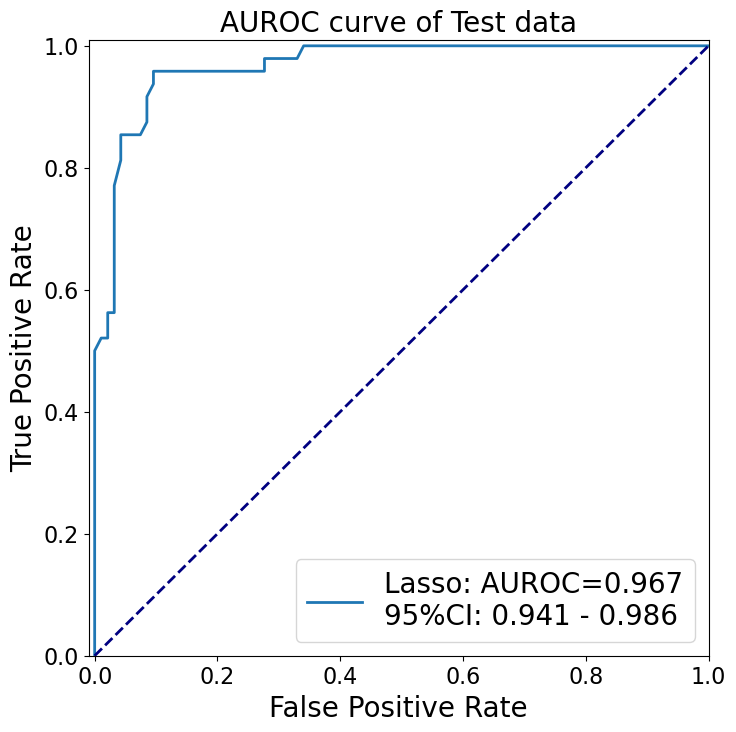

In [52]:
# Draw the AUROC curve for the test dataset
y_pred=prob[:,-1]
plt.figure(figsize=(8, 8))
exp_to_run='AUROC curve of Test data'
fpr, tpr, _ = roc_curve(ytest, y_pred)
r , l = CI(ytest, y_pred)
raw=roc_auc_score(ytest,y_pred)
tex = 'Lasso: AUROC={:0.3f}\n95%CI: {:0.3f} - {:0.3f}'.format(raw,r,l)
plt.plot(fpr, tpr, lw=2, label=tex)
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontdict={'size'   : 20})
plt.ylabel('True Positive Rate', fontdict={'size'   : 20})
plt.title(exp_to_run, fontdict={'size'   : 20})
plt.yticks(size = 16) 
plt.xticks(size = 16)  
plt.legend(loc="lower right",fontsize=20)
plt.savefig("Figures/{}_roc.pdf".format("Test"))
plt.show()

In [44]:
imp=model.feature_importances_
feature_importances=pd.concat([pd.DataFrame(Counts_metas['metas'][0:10]),pd.DataFrame(imp)],axis=1)
feature_importances.columns=['feature_name','importance_score']
feature_importances

,feature_name,importance_score
0,Succinate_neg-079,0.217982
1,Uridine_neg-088,0.187322
2,S-Adenosyl-methionine_pos-139,0.112335
3,N-Acetyl-D-glucosamine 6-phosphate_neg-061,0.057358
4,Serotonin_pos-142,0.051374
5,Pyroglutamic acid_neg-072,0.078351
6,Neopterin_pos-117,0.059755
7,Lactic acid_neg-055,0.125327
8,2-Aminooctanoic acid_pos-006,0.061083
9,NMN_pos-162,0.049113


In [45]:
####### Using external test dataset to validate the model.
# read external test data
Xexternal_test = pd.read_excel('Data/Xexternal_test.xlsx',index_col=0)
yexternal_test = pd.read_excel('Data/yexternal_test.xlsx',index_col=0)

yexternal_test=pd.DataFrame(yexternal_test)
Xexternal_test.drop(['sample_id'],axis=1,inplace=True)
metas=list(Xexternal_test.columns)

yexternal_test = np.array(yexternal_test.state)
yexternal_test = yexternal_test.astype(np.float32)
Xexternal_test= Xexternal_test.values
print("test, normal-patients", np.unique(yexternal_test,return_counts=True))

external_test_s=[]
external_test_s1=[]
external_test_pred = model.predict(Xexternal_test[:,selected_feature_index])
external_test_prob = model.predict_proba(Xexternal_test[:,selected_feature_index])
print("ytest,pred:",yexternal_test,external_test_pred)
external_test_s.append(f1_score(yexternal_test, external_test_pred))
print("ytest,prob:",yexternal_test,external_test_prob[:,-1])
external_test_s1.append(roc_auc_score(yexternal_test, external_test_prob[:,-1]))
print("f1 score:", external_test_s)
print("auroc score:", external_test_s1)

auroc score: 0.9201388888888888
Confidence interval for the score: [0.868 - 0.965]


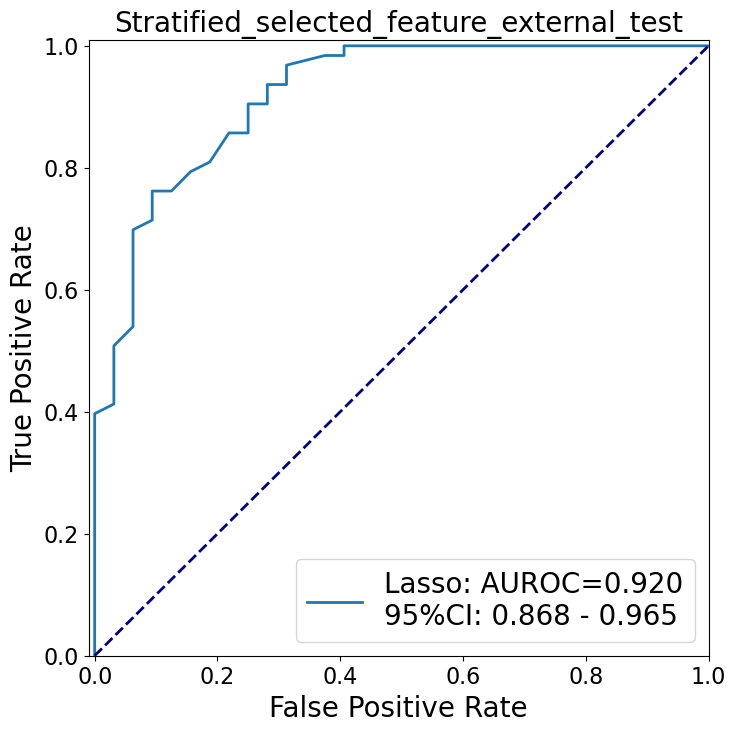

In [50]:
# Draw the AUROC curve for the external test dataset
y_pred_external=external_test_prob[:,-1]
plt.figure(figsize=(8, 8))
exp_to_run='Stratified_selected_feature_external_test'
fpr, tpr, _ = roc_curve(yexternal_test, y_pred_external)
r , l = CI(yexternal_test, y_pred_external)
raw=roc_auc_score(yexternal_test, y_pred_external)
tex = 'Lasso: AUROC={:0.3f}\n95%CI: {:0.3f} - {:0.3f}'.format(raw,r,l)
plt.plot(fpr, tpr, lw=2, label=tex)
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontdict={'size'   : 20})
plt.ylabel('True Positive Rate', fontdict={'size'   : 20})
plt.title(exp_to_run, fontdict={'size'   : 20})
plt.yticks(size = 16) 
plt.xticks(size = 16)  
plt.legend(loc="lower right",fontsize=20)
plt.savefig("Figures/{}_external_test_roc.pdf".format("Test"))
plt.show()